In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

# matplotlib 한글 깨짐 해결
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('../final_data.csv')
data.shape

(753454, 49)

# 좌석 정보 추출

In [3]:
# 층 정보 추출
data['floor'] = data['seat'].apply(lambda x: x.split()[0])
# 블록/박스 정보 추출
data['block'] = data['seat'].apply(lambda x: x.split()[1])
# 좌석 자리 추출
data['seat_num'] = data['seat'].apply(lambda x: int(x.split()[2]))
# 열 추출
data['row'] = data['seat'].str.extract(r'(\d+)열')

In [4]:
# 열 NaN 값 처리
data['row'].fillna(0, inplace=True)
data['row'] = data['row'].astype(int)

In [5]:
# 블록/박스에서 블록 이름 추출
data['block'] = data['block'].apply(lambda x: x[x.index('블록')-1] if '블록' in x else x)

# 초대석, 기획사 판매 제외

In [6]:
df = data.copy()
discard = df[(df['price']==0) & ((df['discount_type'].str.contains('초대')) | (df['discount_type'].str.contains('기획사판매')))]['key'] # 395,000
df = df[~df['key'].isin(discard)] # 358,454

In [7]:
df.shape

(358454, 53)

# 시각화

In [8]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

data['age'].fillna(0, inplace=True)

df = data.copy()

encoder_dict = {}

le = LabelEncoder()
df['age'] = le.fit_transform(data['age'])

encoder_dict['age'] = le.classes_
encoder_dict

{'age': array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.])}

        나이

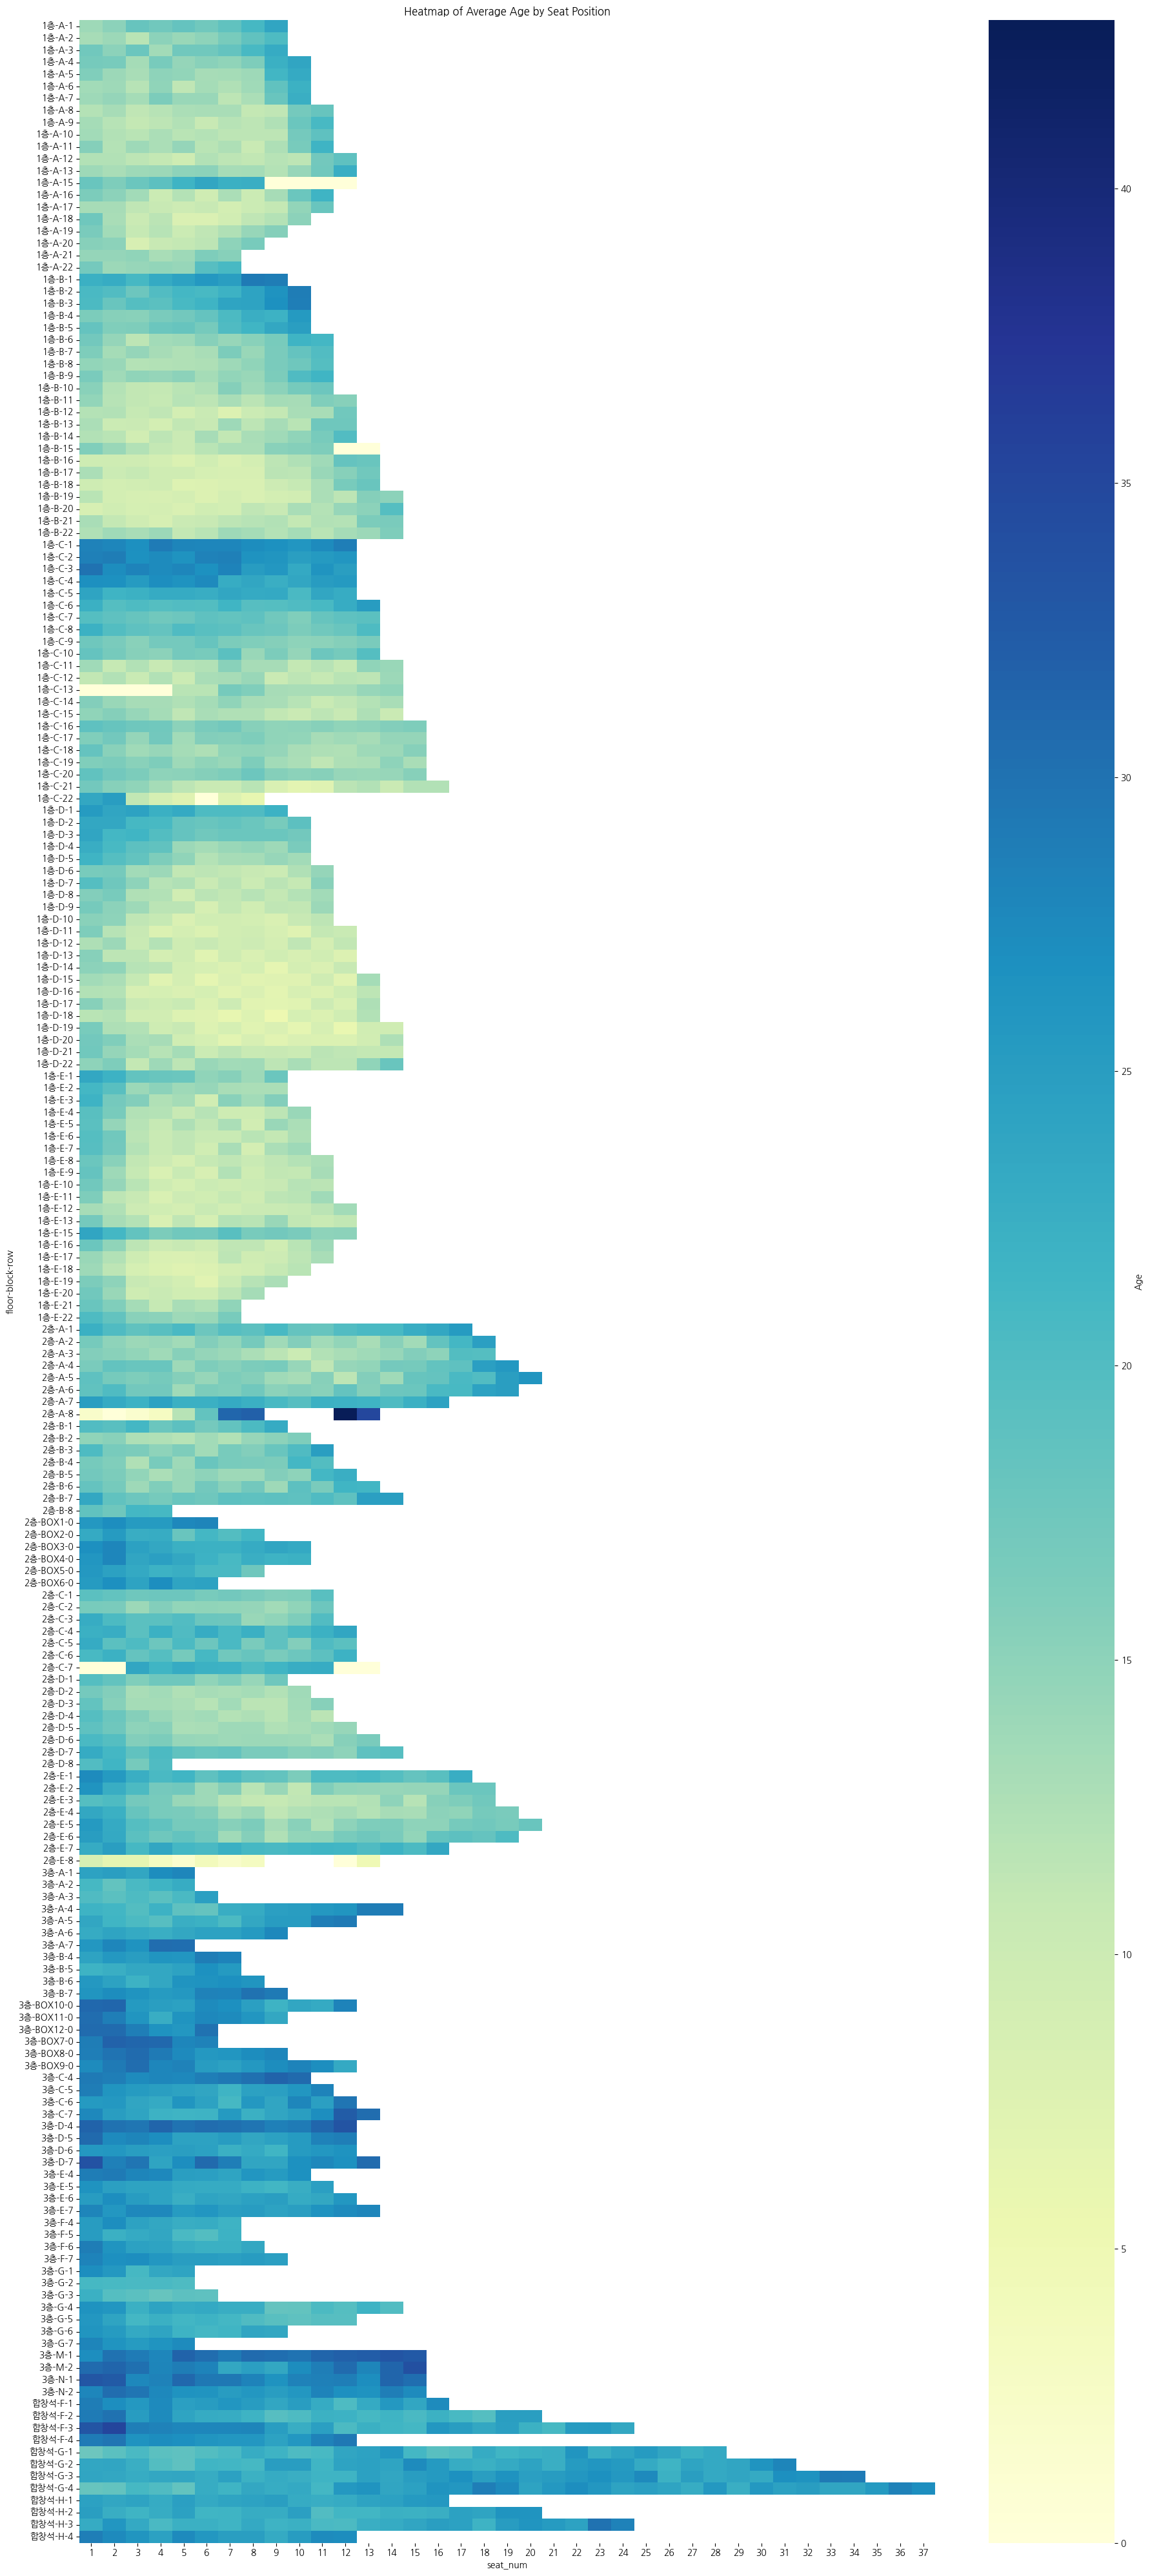

In [16]:
# 데이터 추출
grouped_data_age = data.groupby(['floor', 'block', 'row', 'seat_num'])['age'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
# grouped_data_age = df.groupby(['floor', 'block', 'row', 'seat_num'])['age'].apply(lambda x: x.mode().iloc[0] if not x.empty else None).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_age = grouped_data_age.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='age')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_age, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Age'})
ax.set_title('Heatmap of Average Age by Seat Position')


plt.tight_layout()
plt.show()

        장르별

In [17]:
data['genre'].unique()

array(['교향곡', '독주', '클래식', '오페라', '성악', '실내악', '콘서트', '합창', '복합장르'],
      dtype=object)

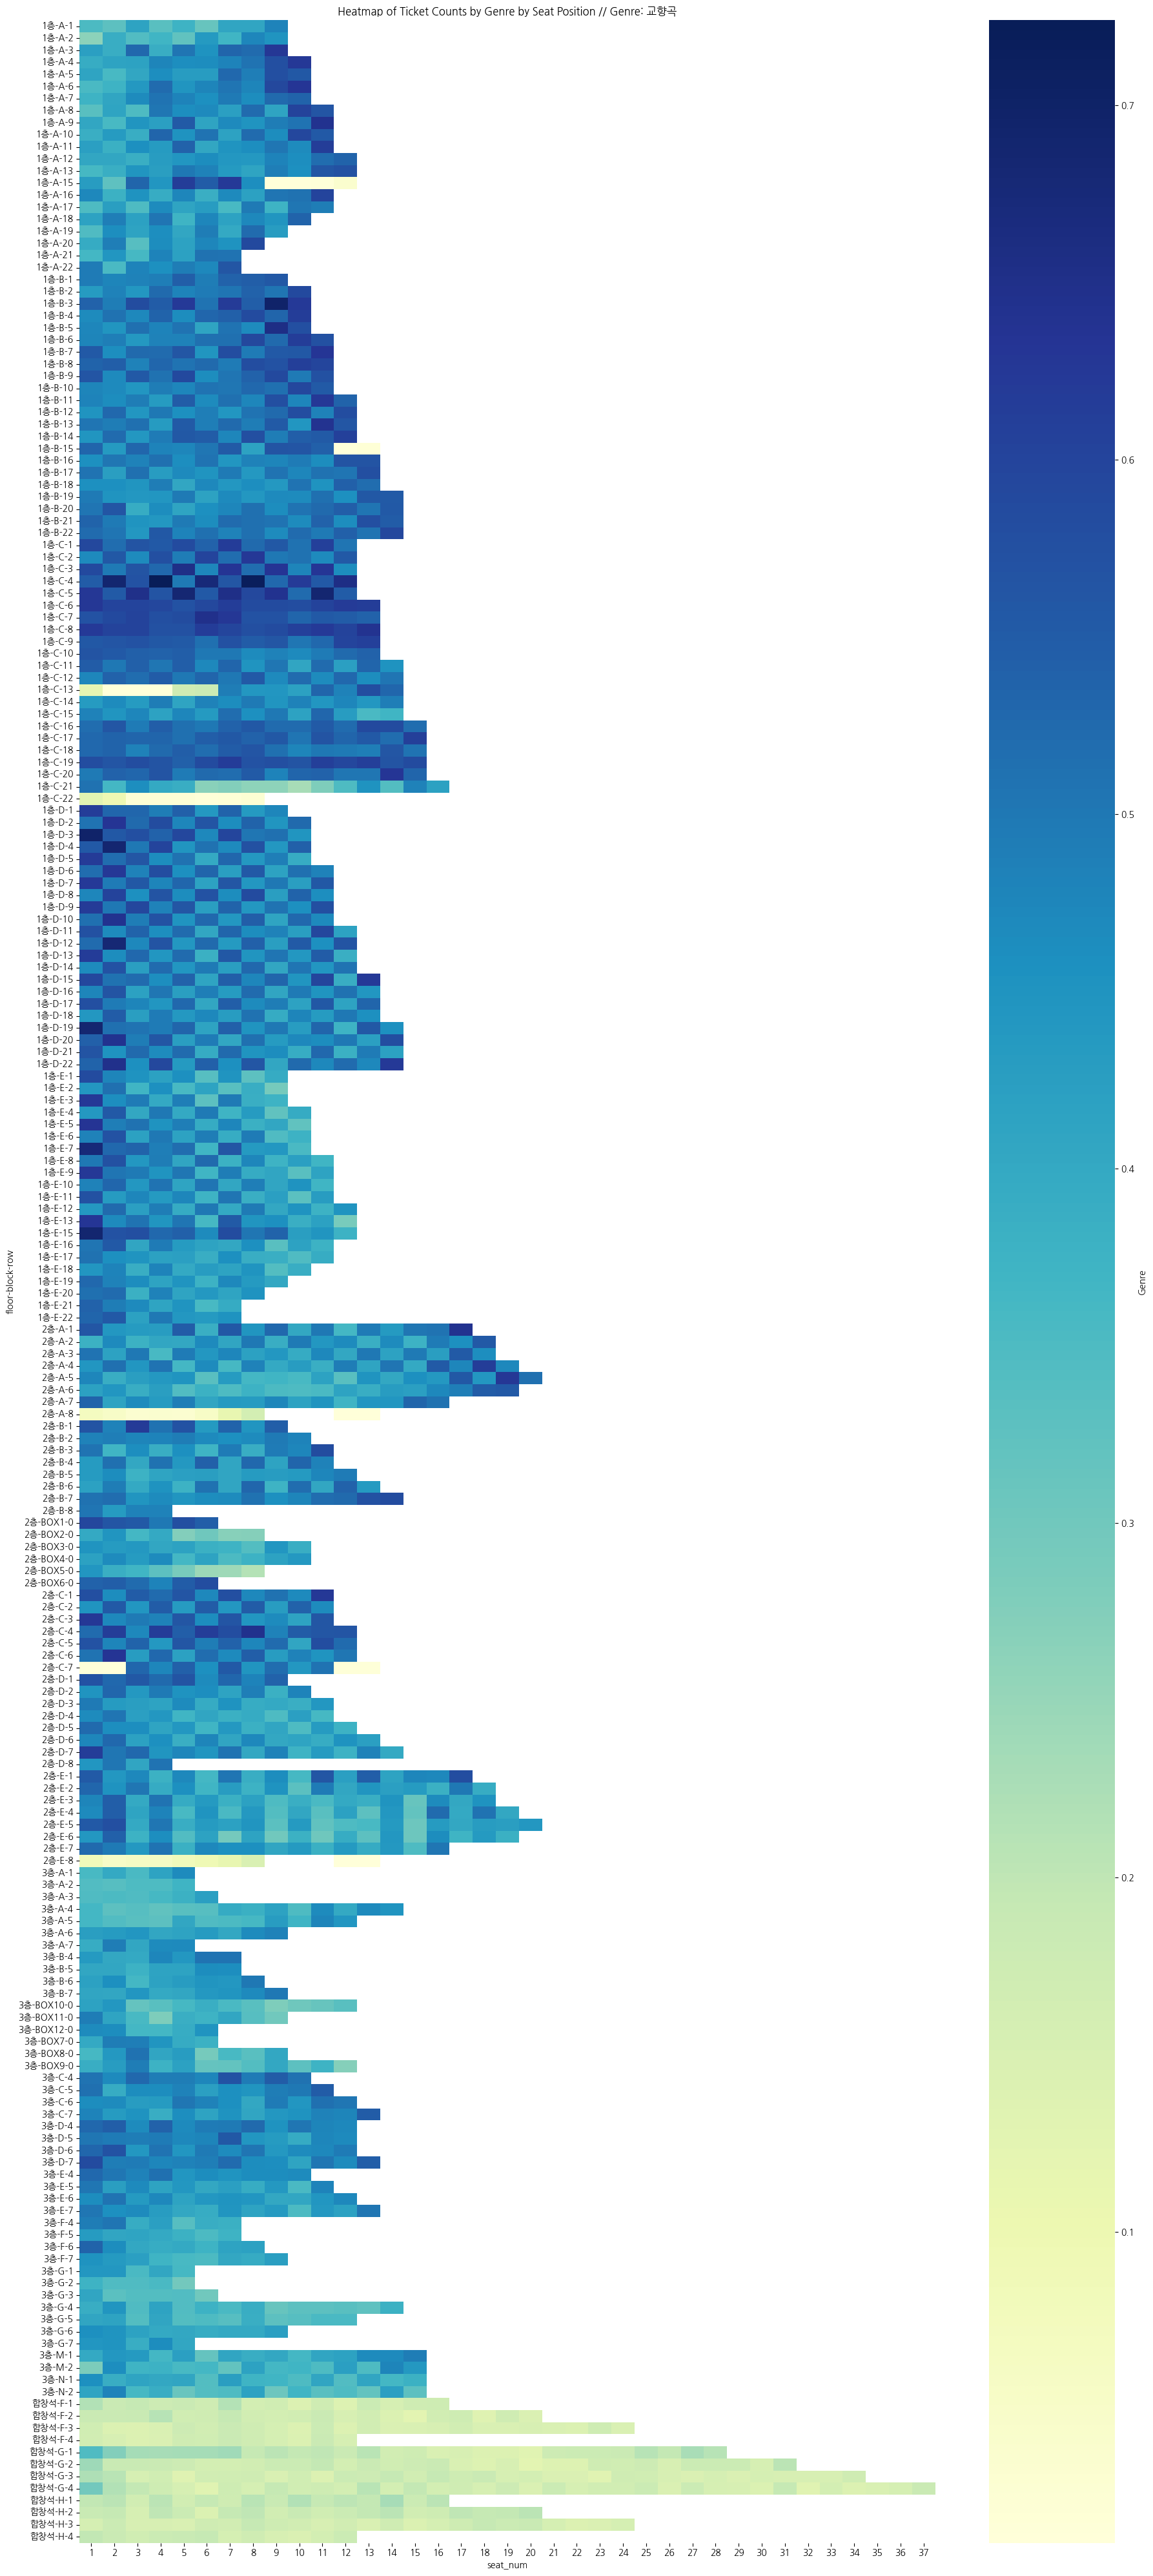

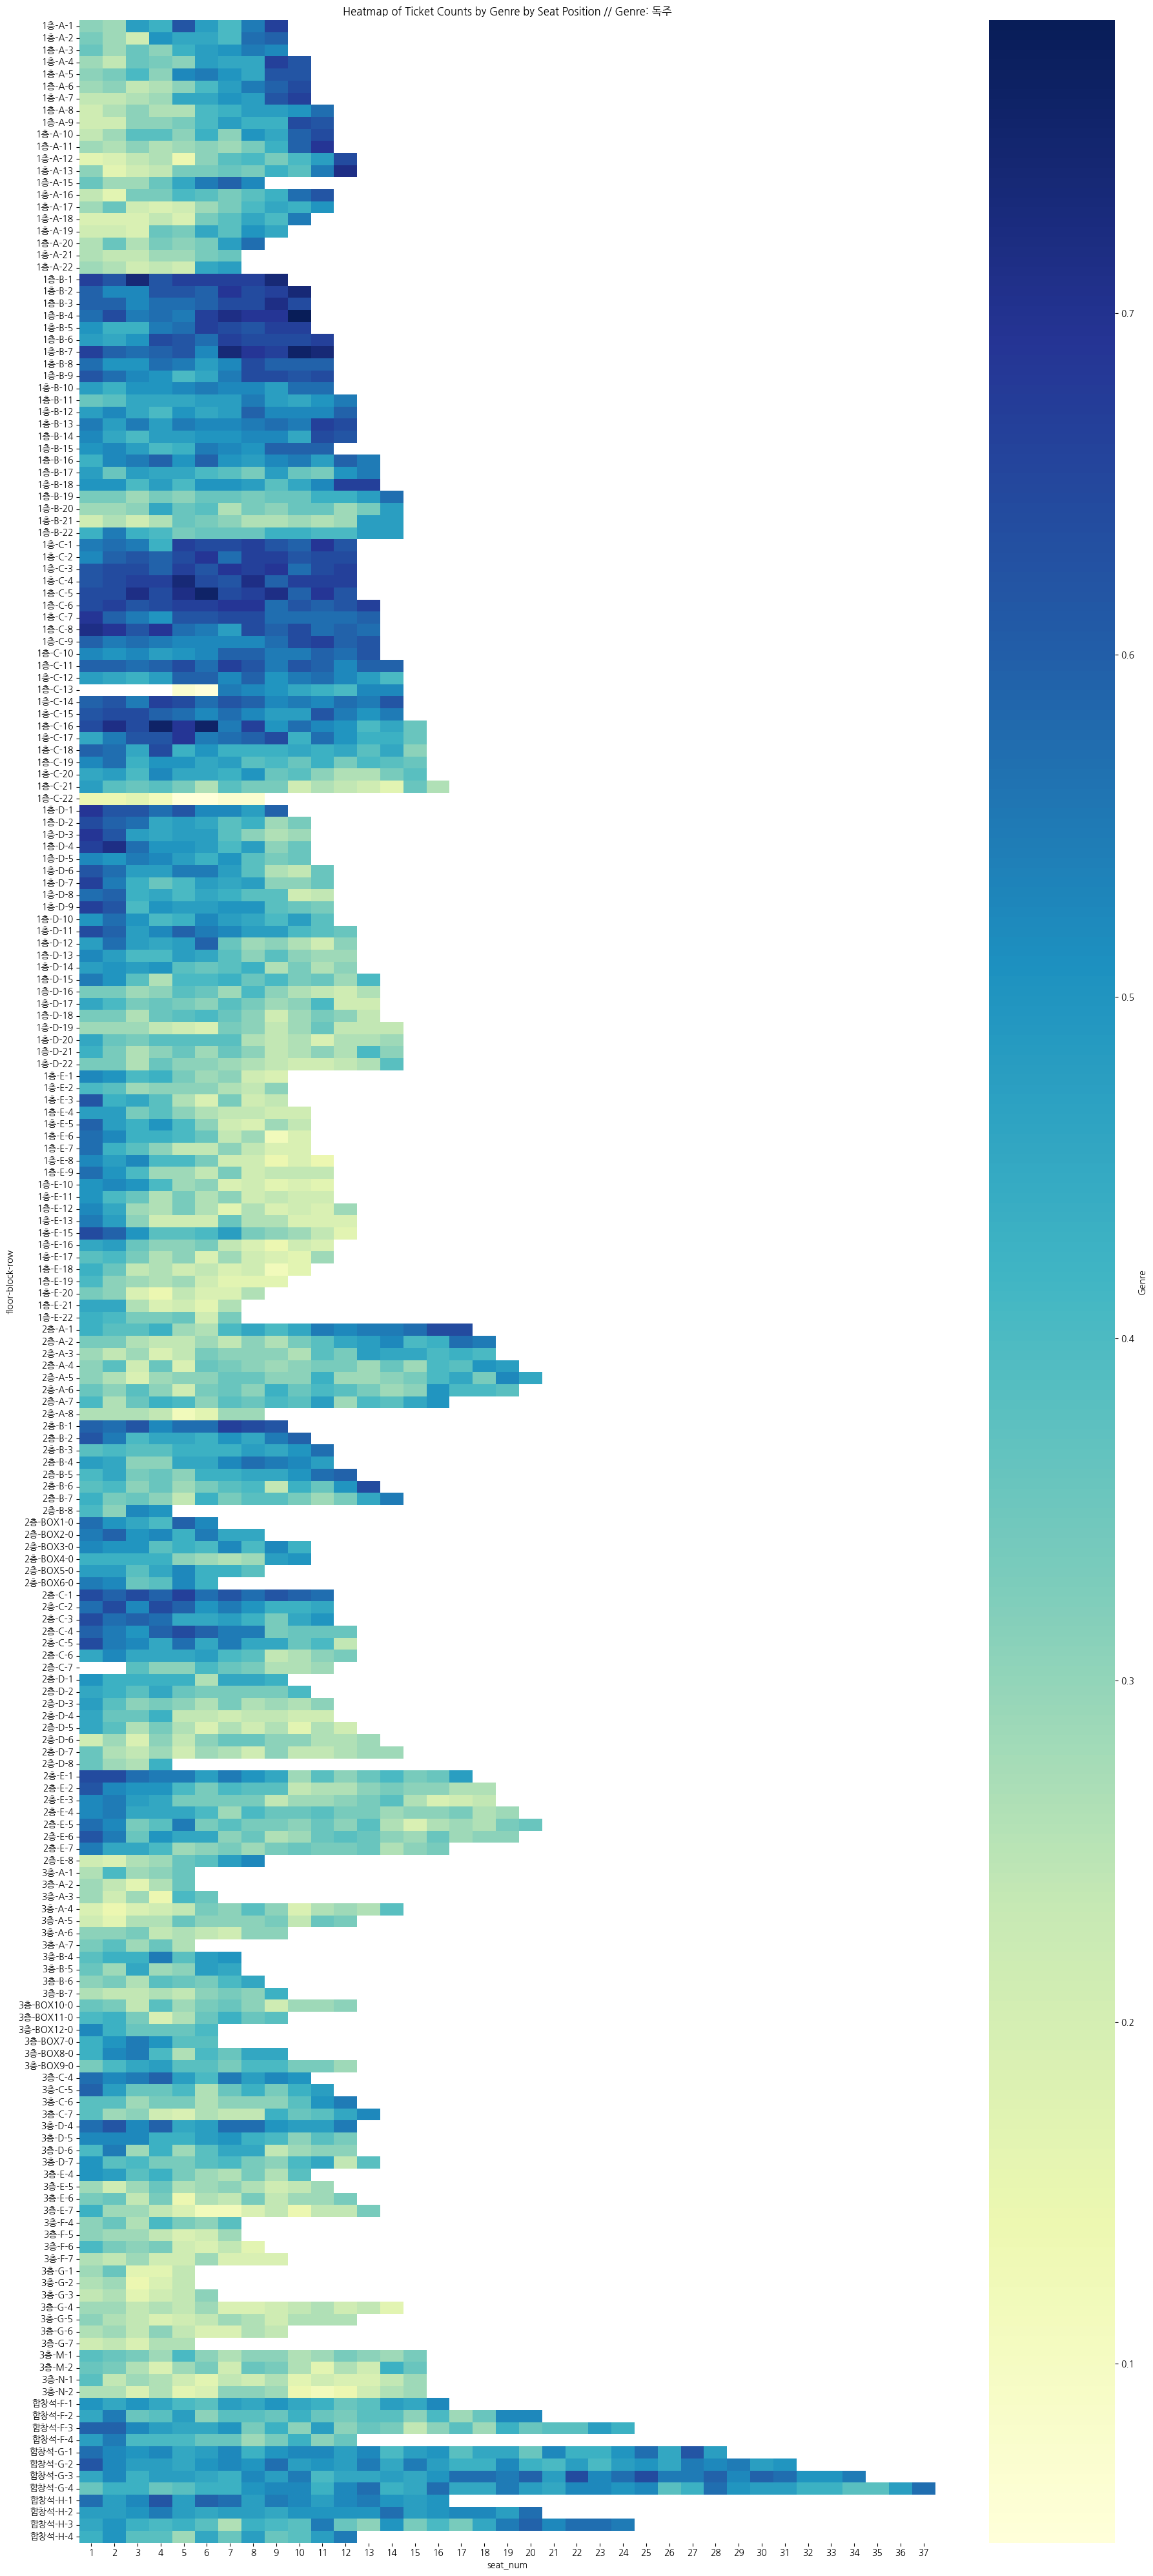

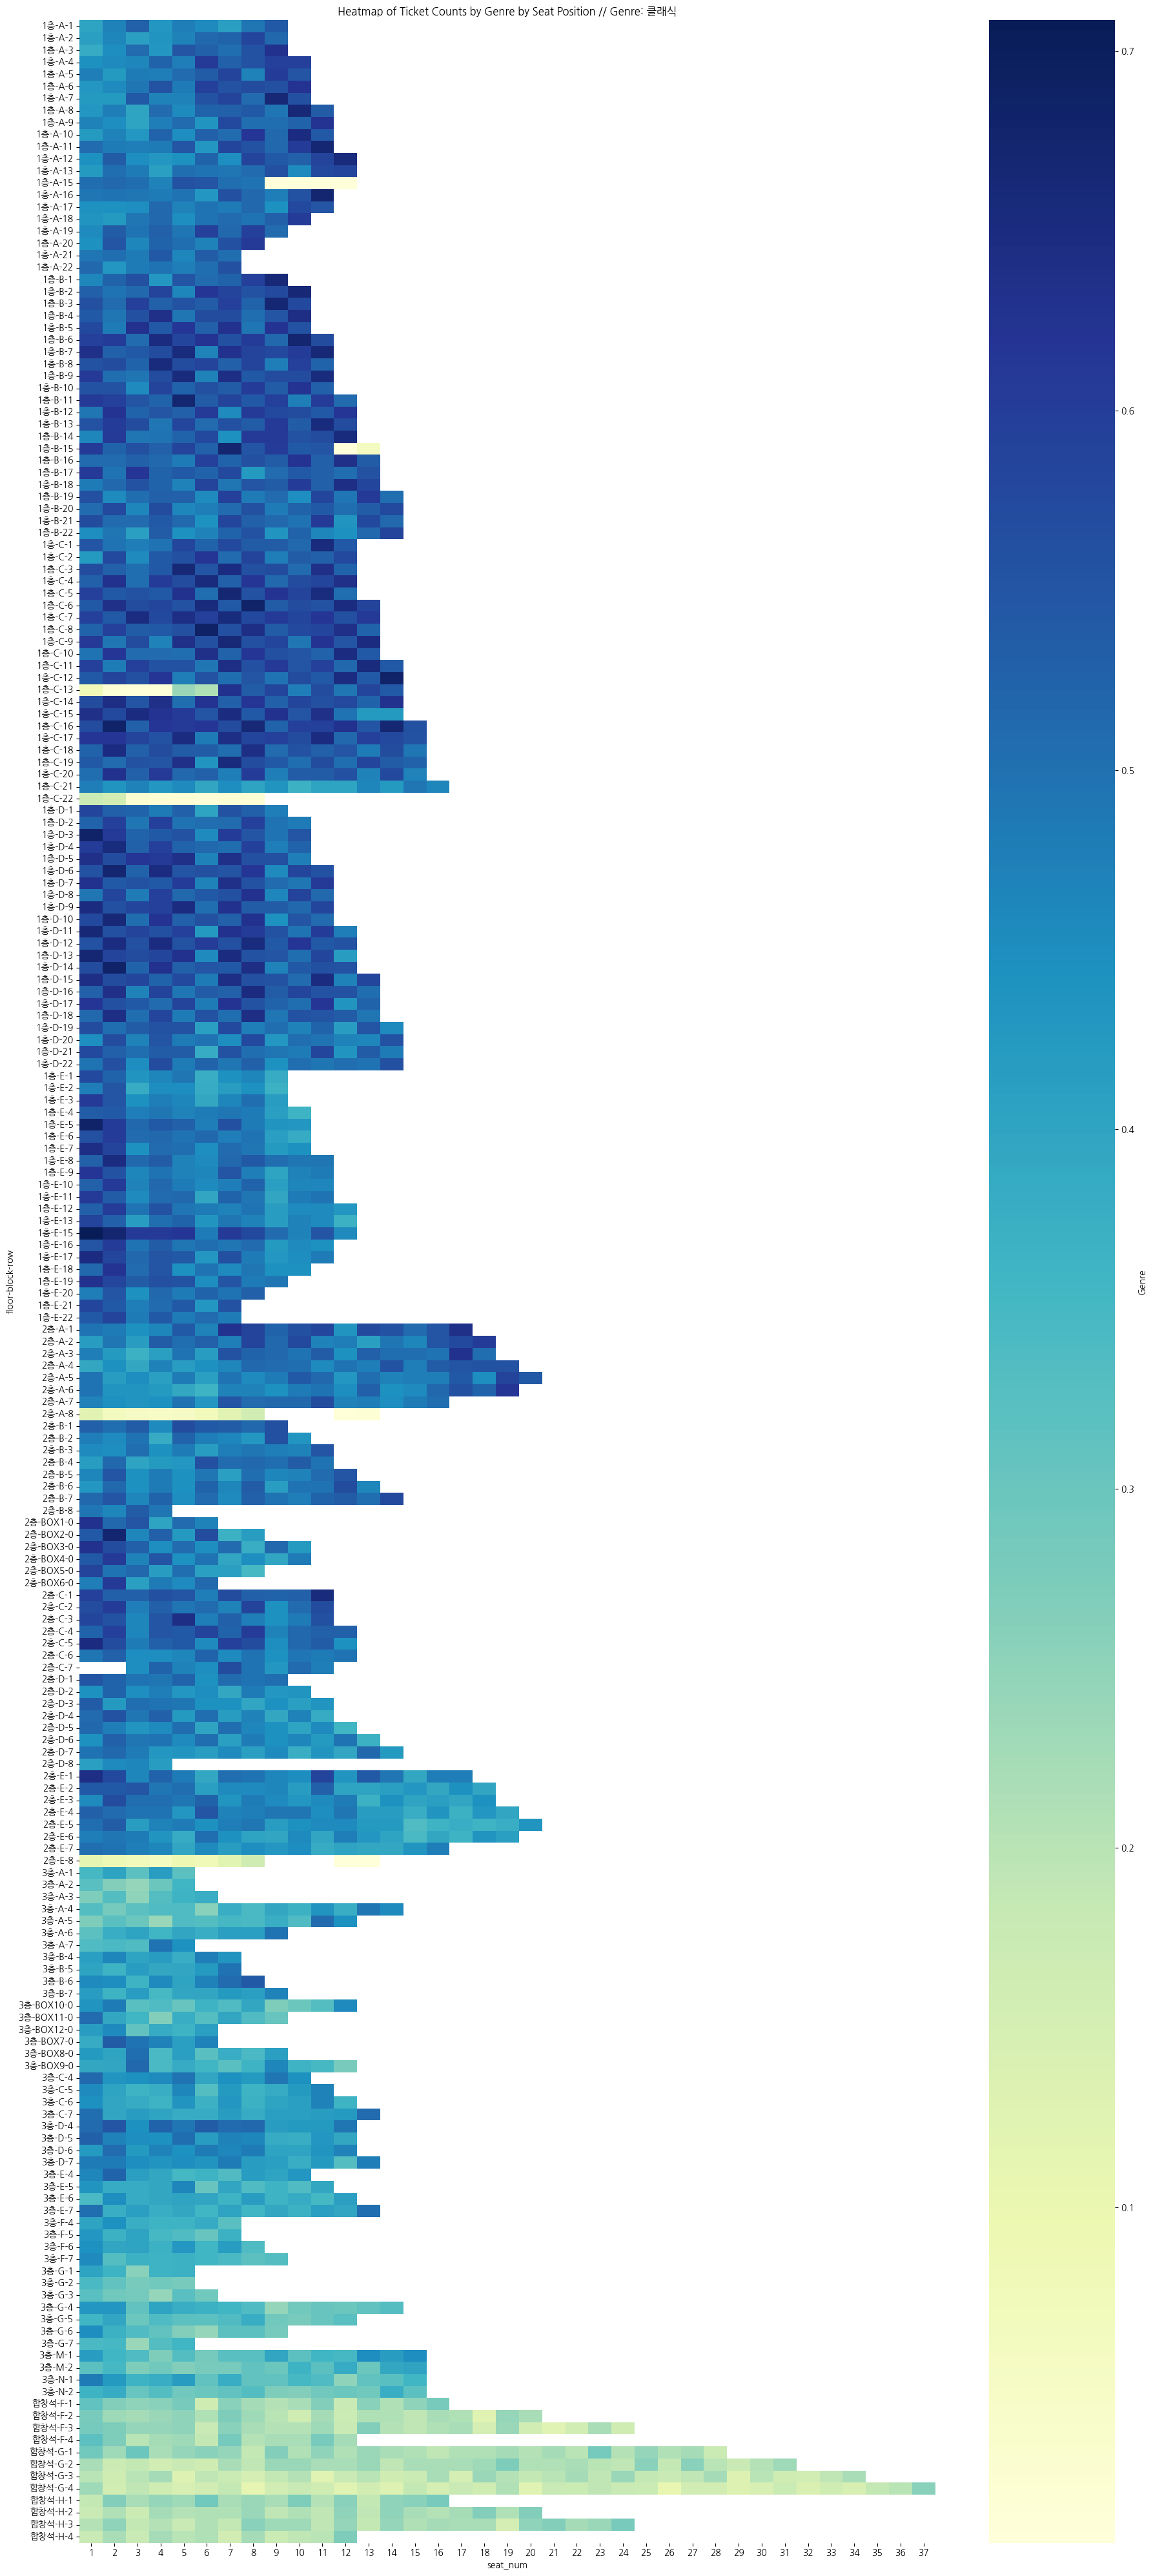

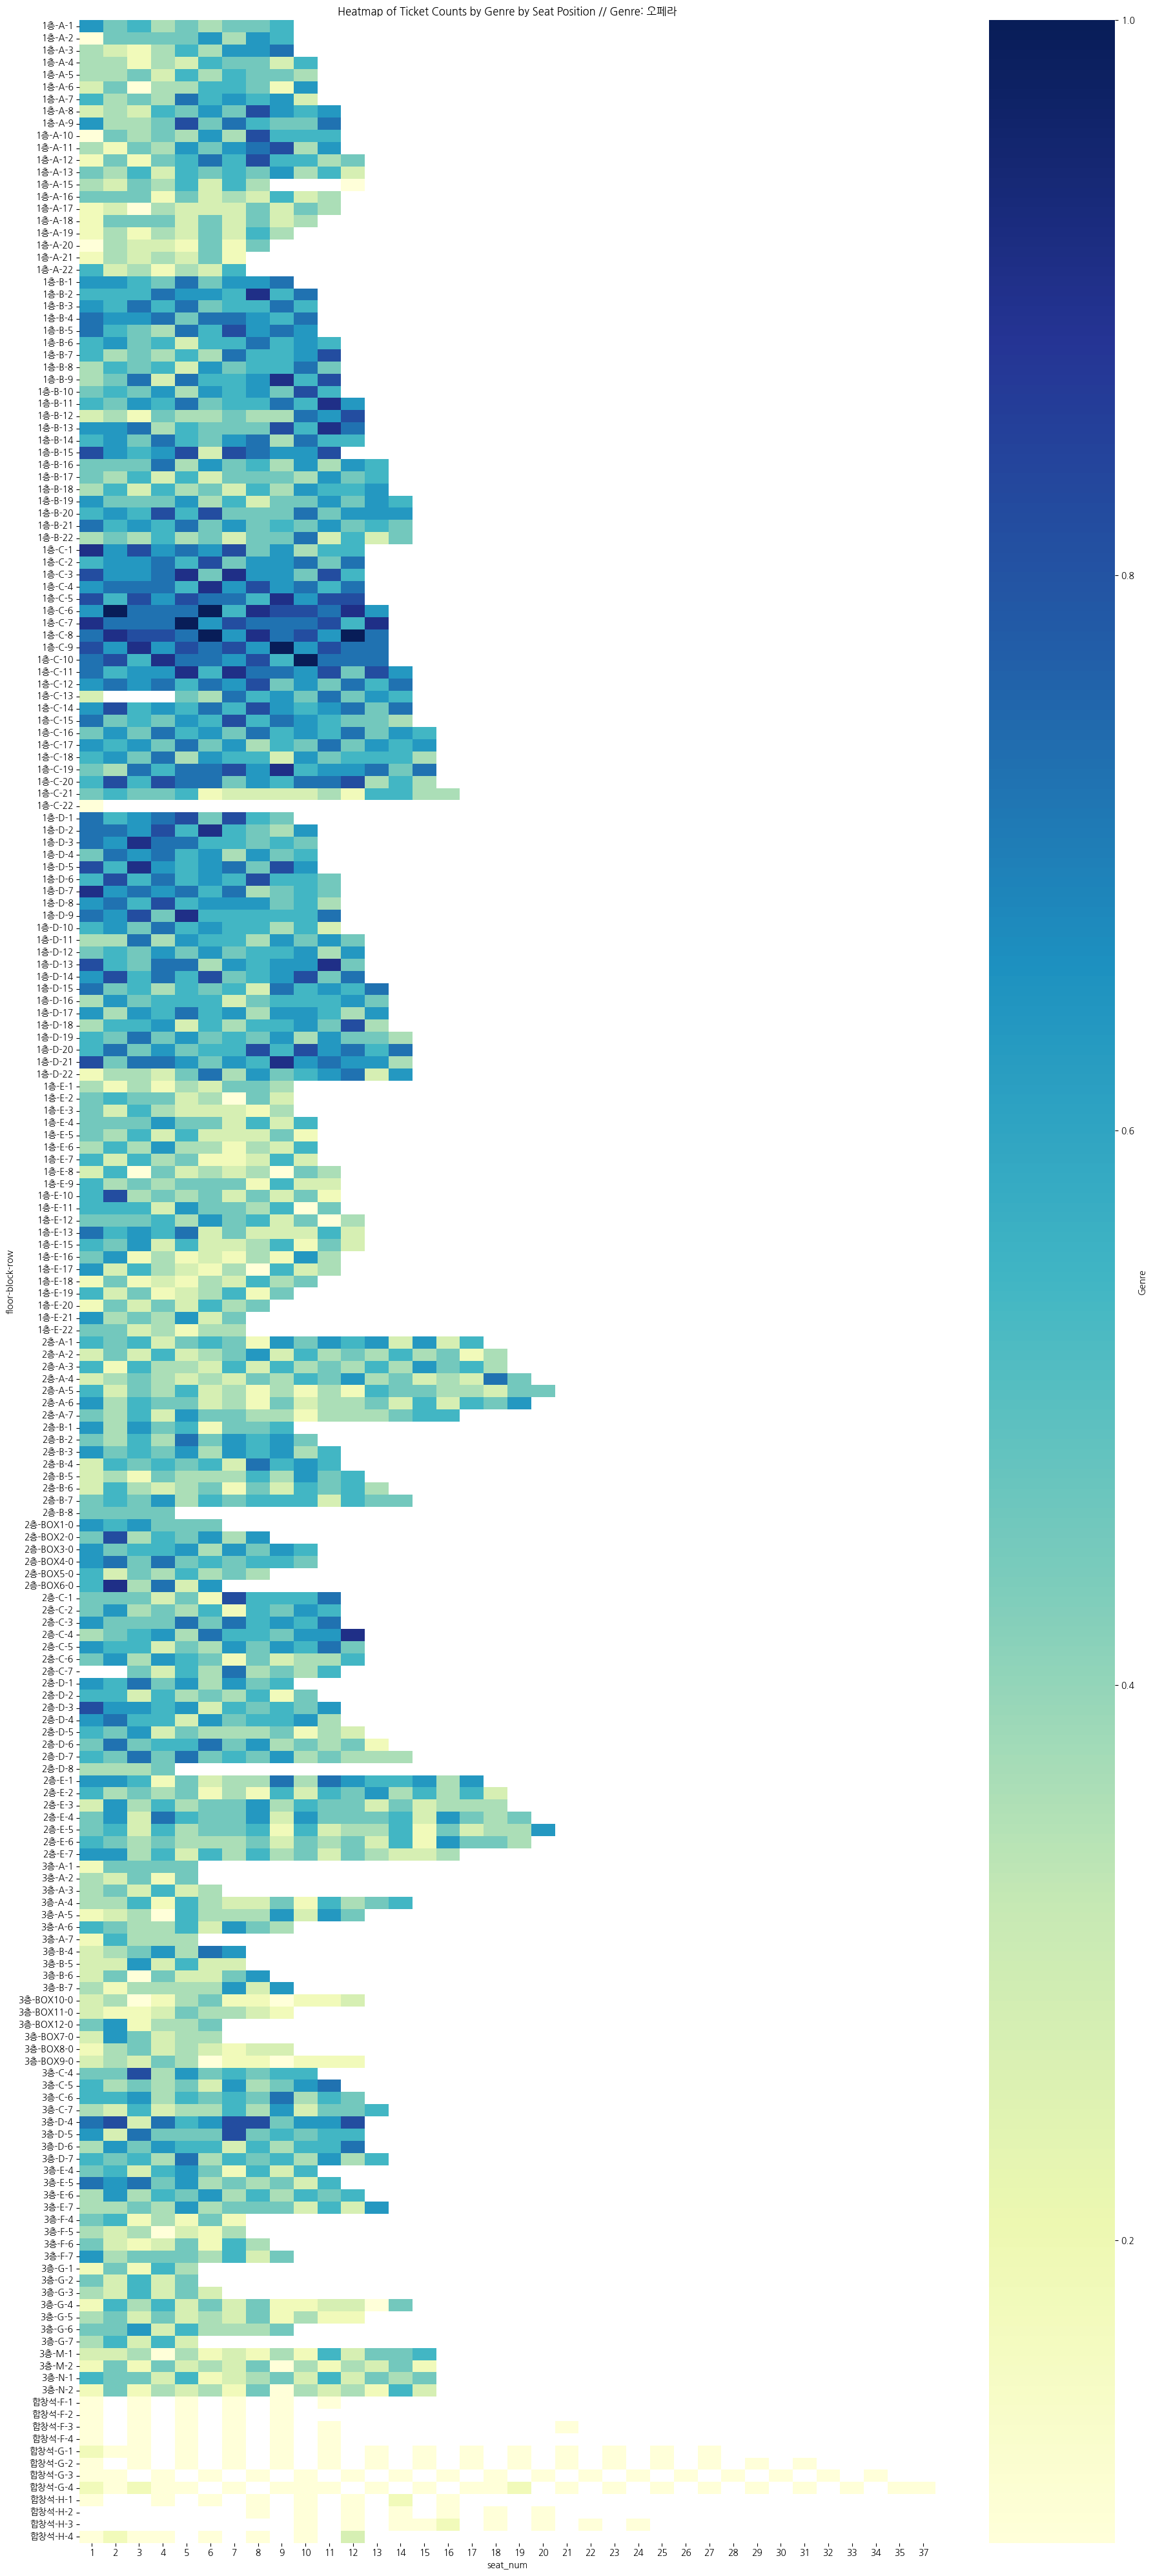

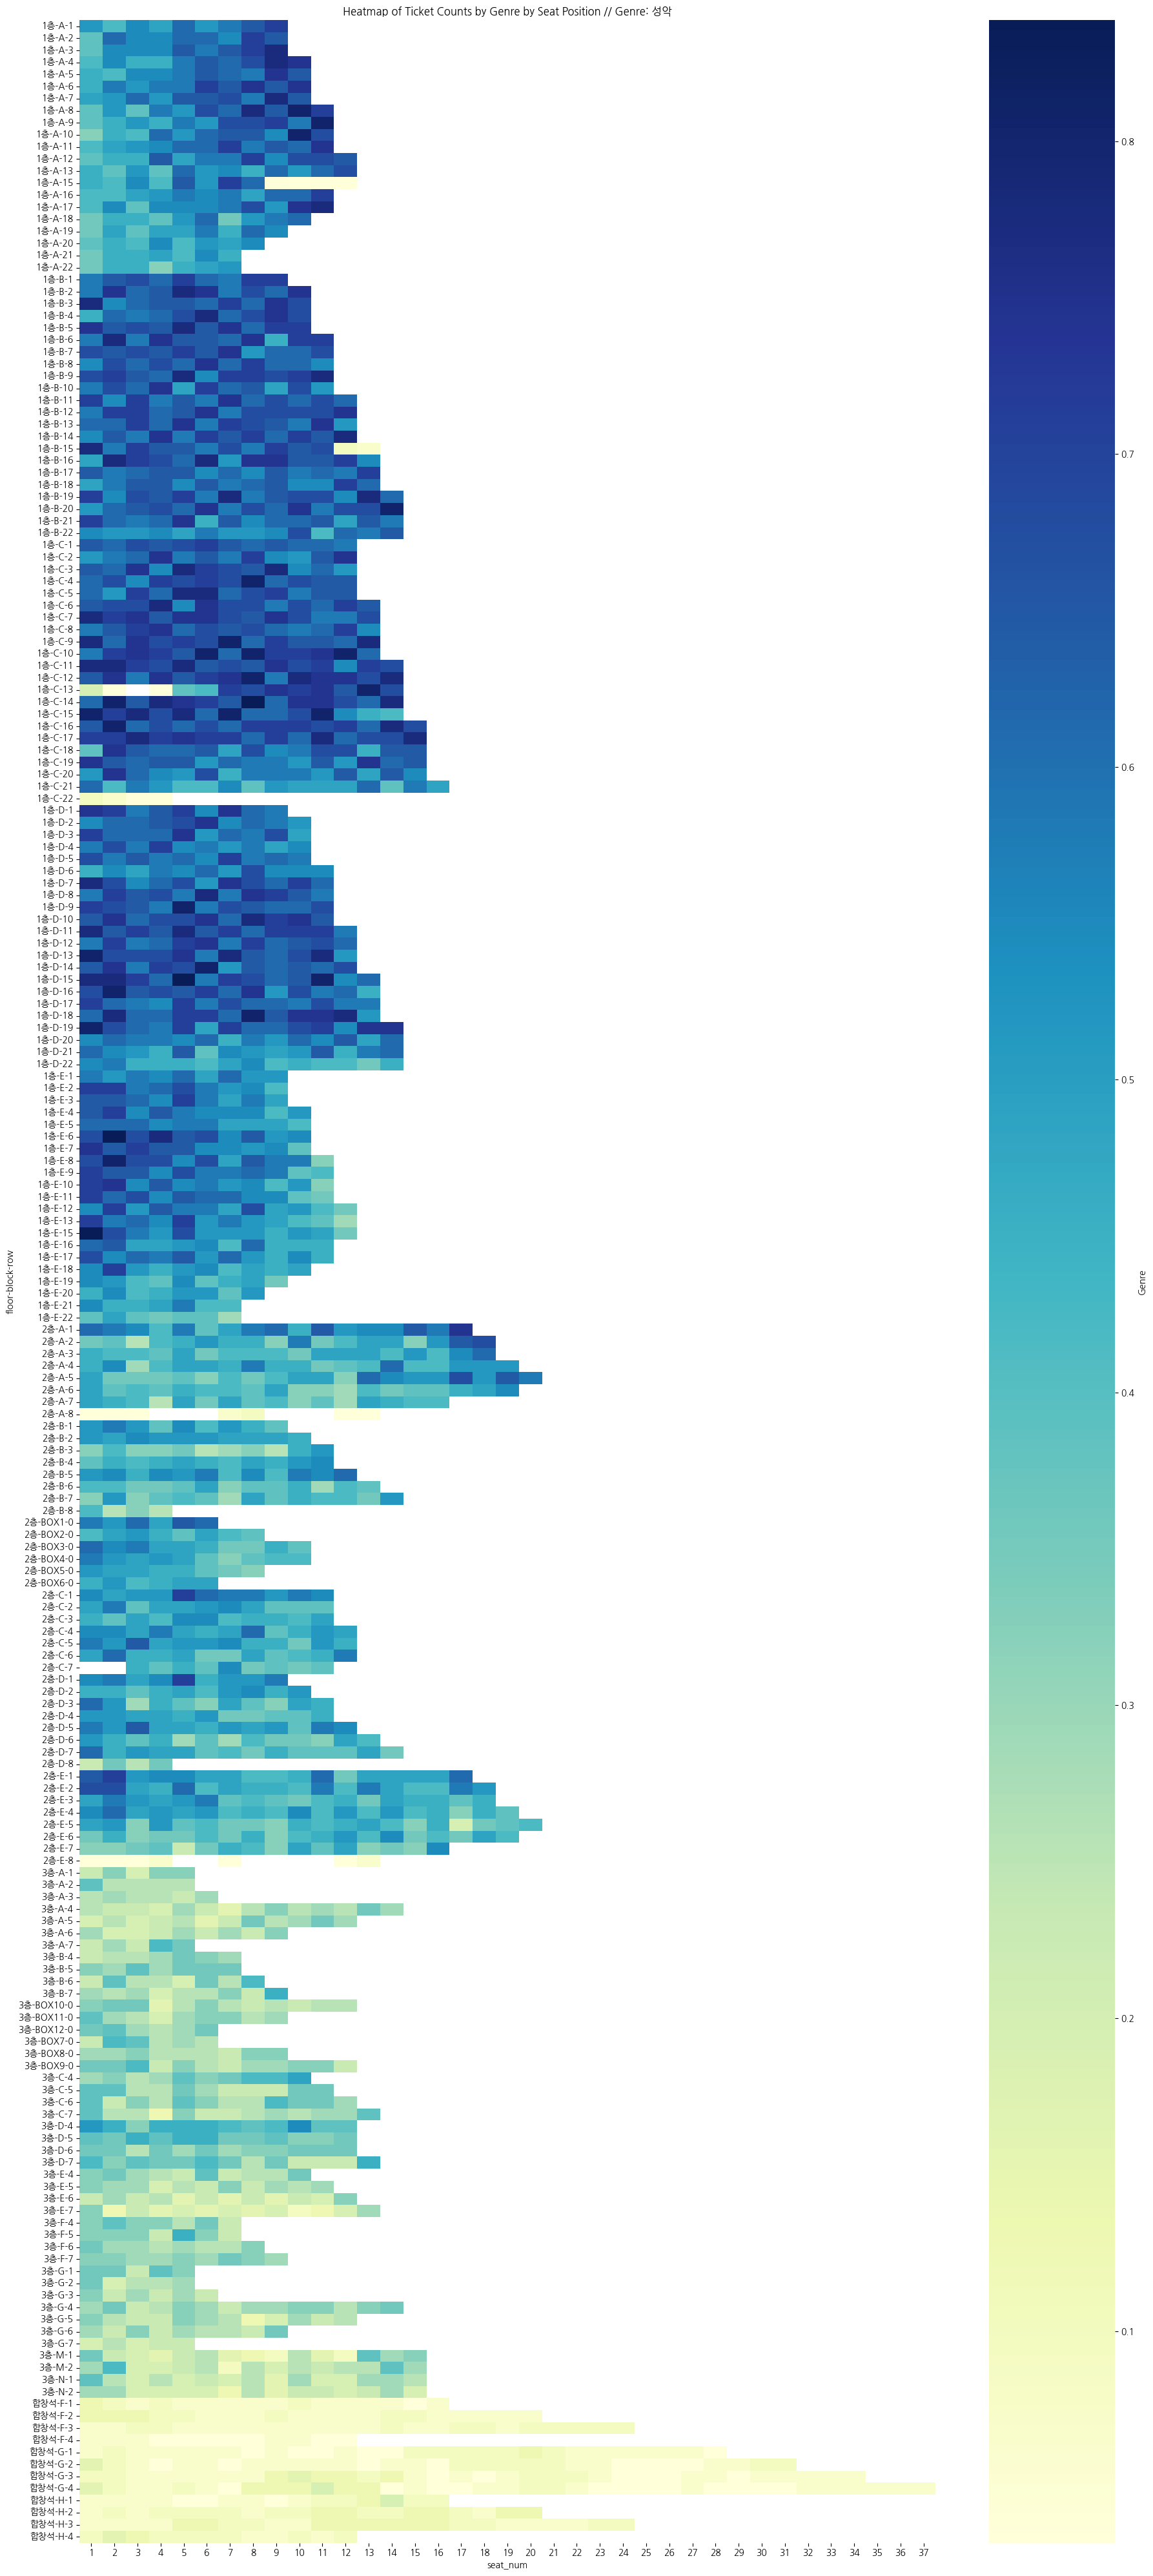

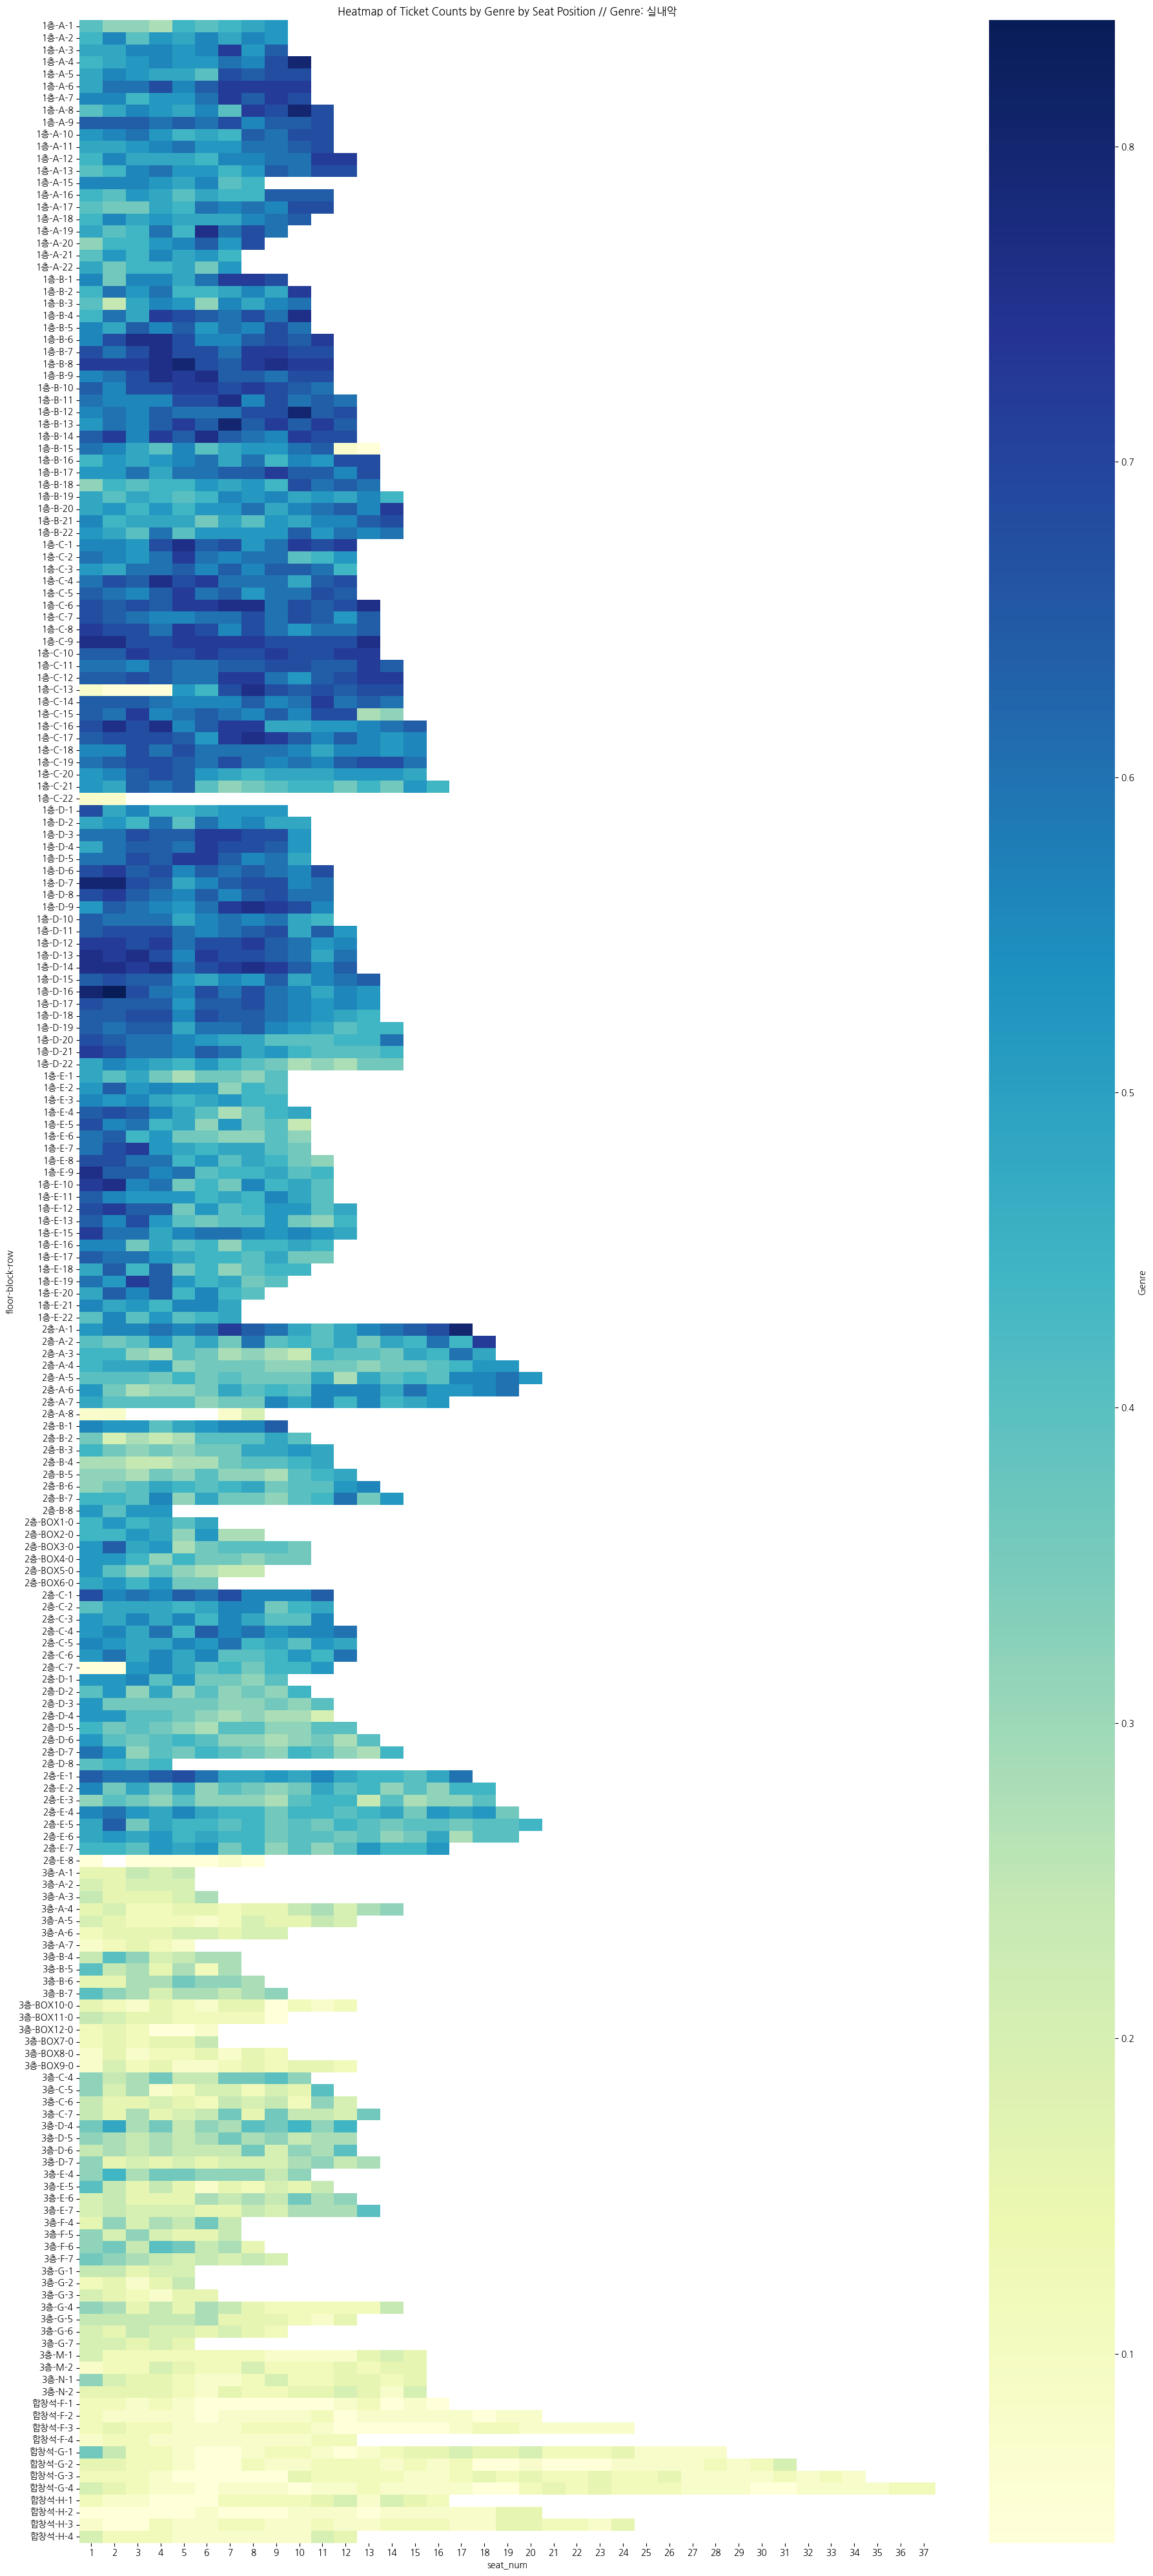

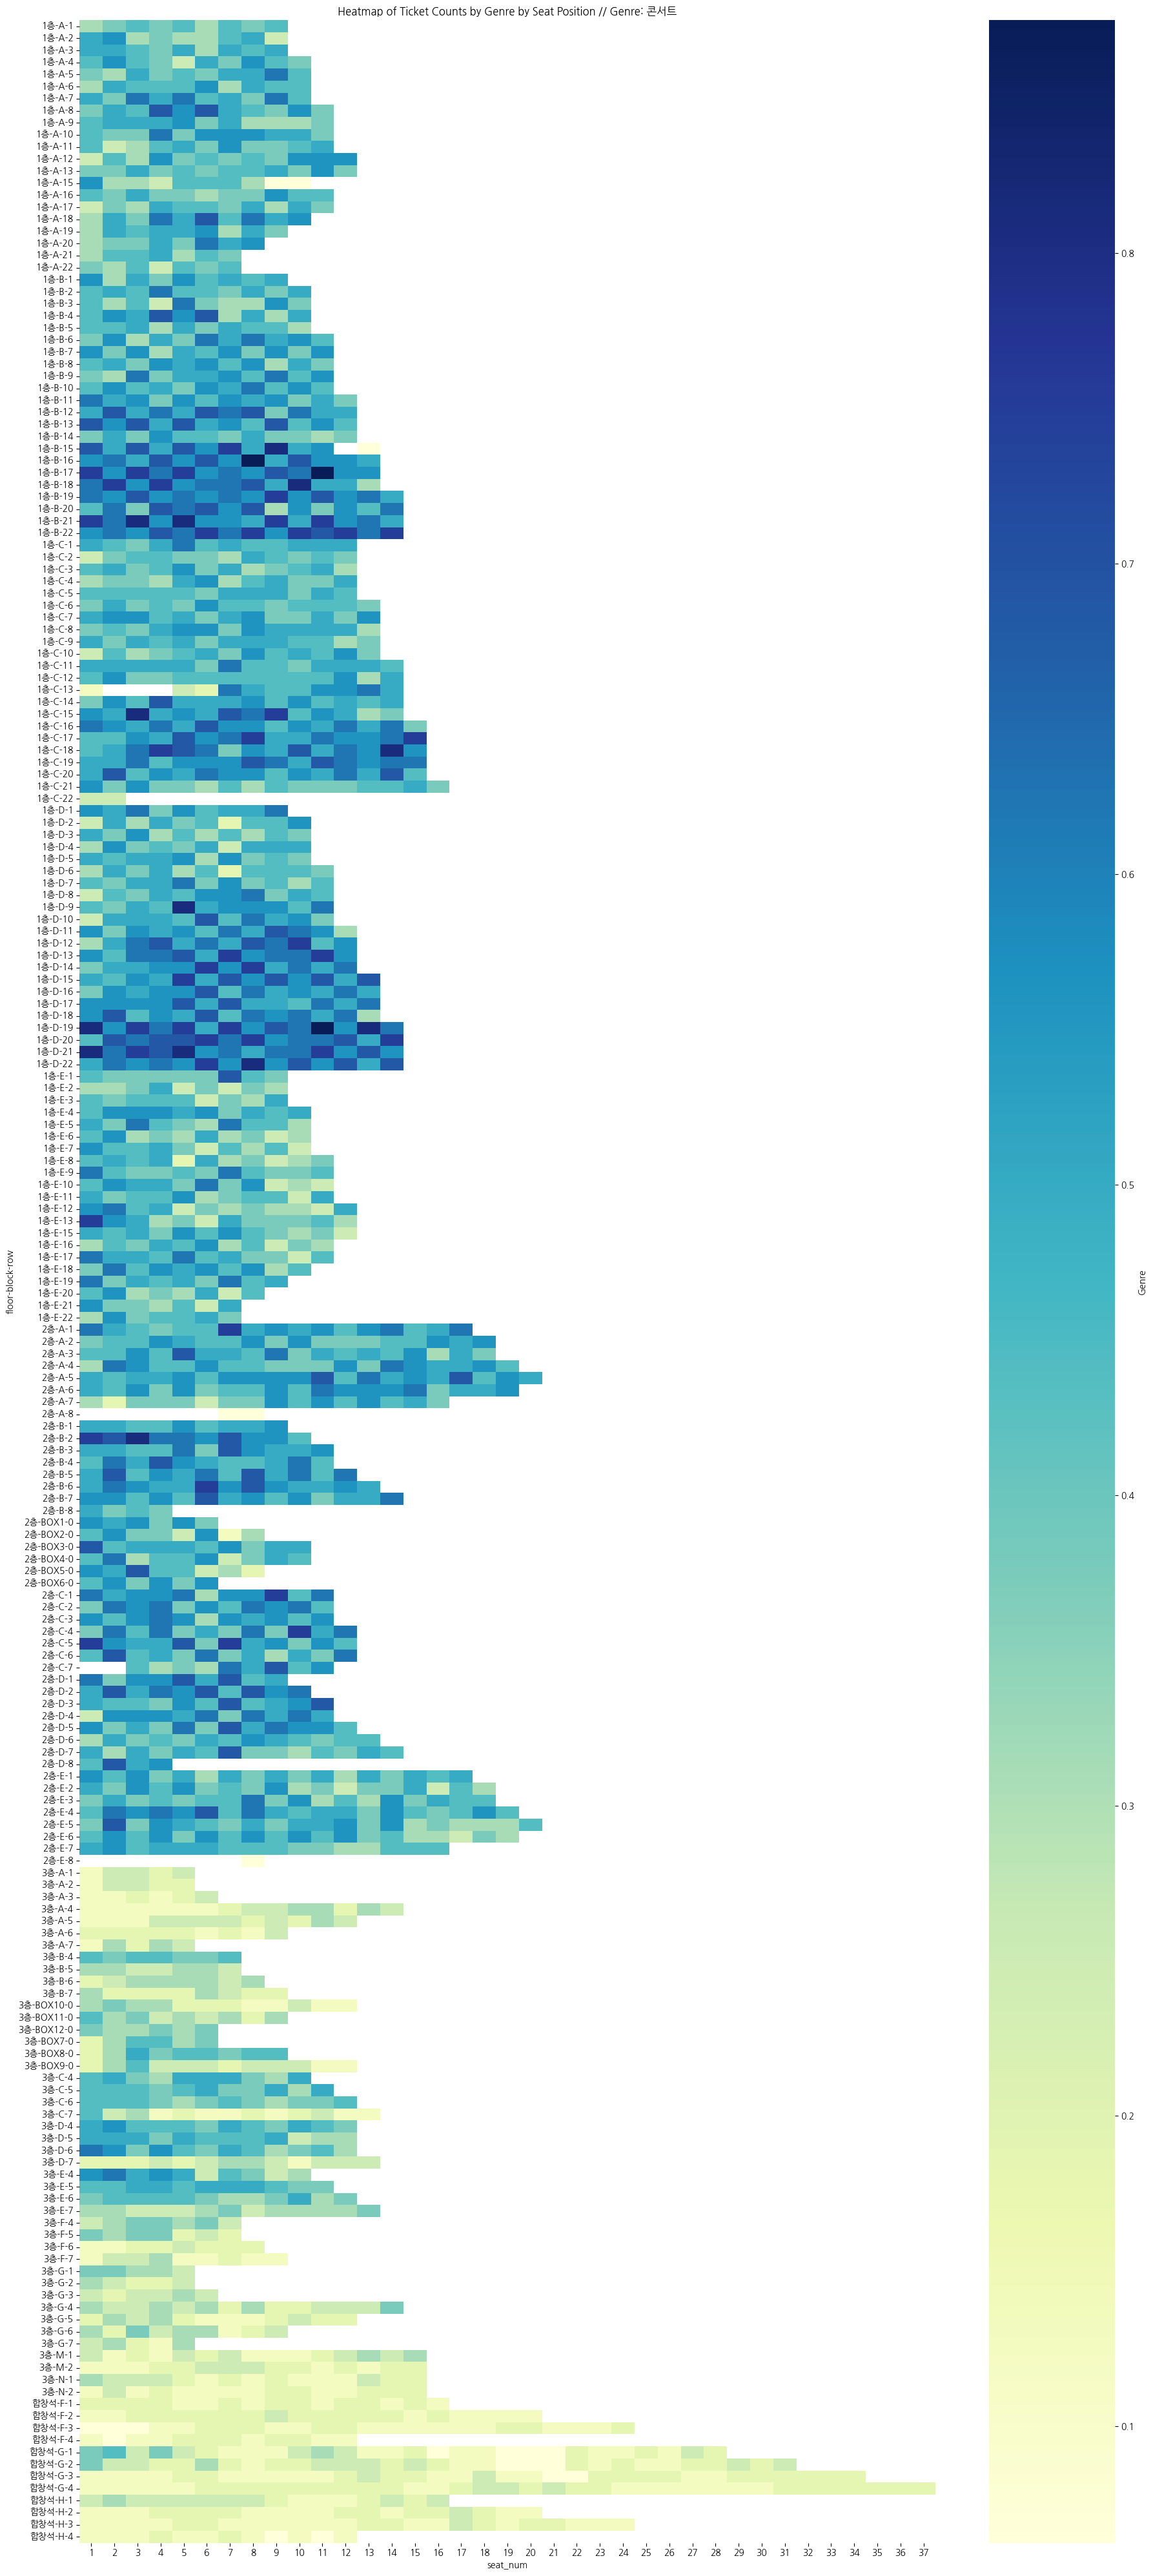

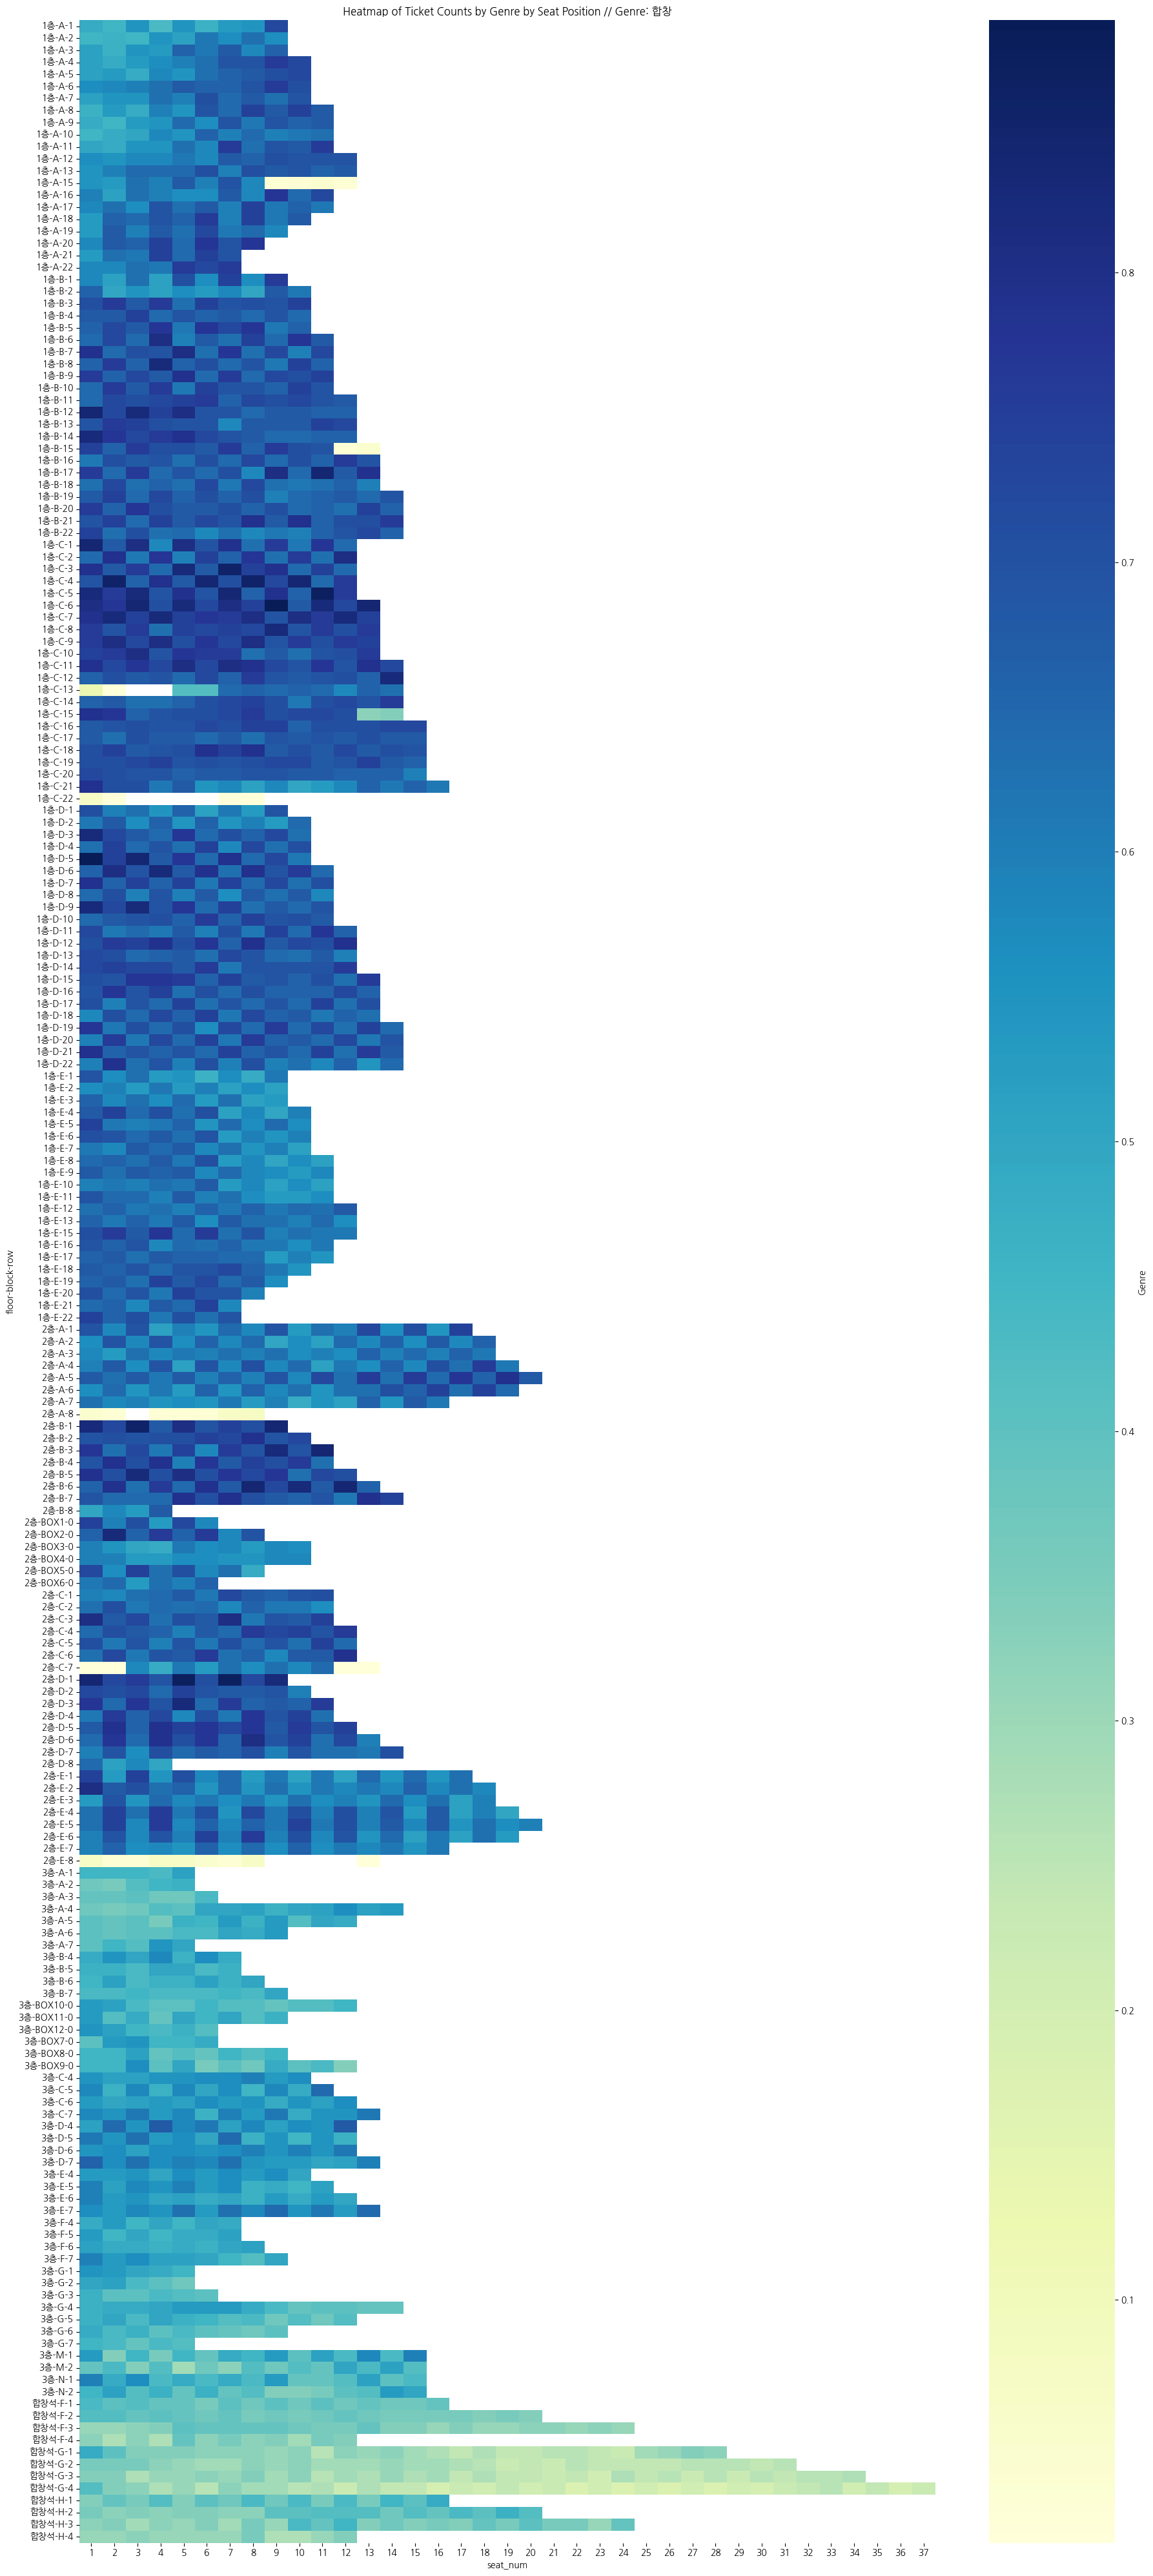

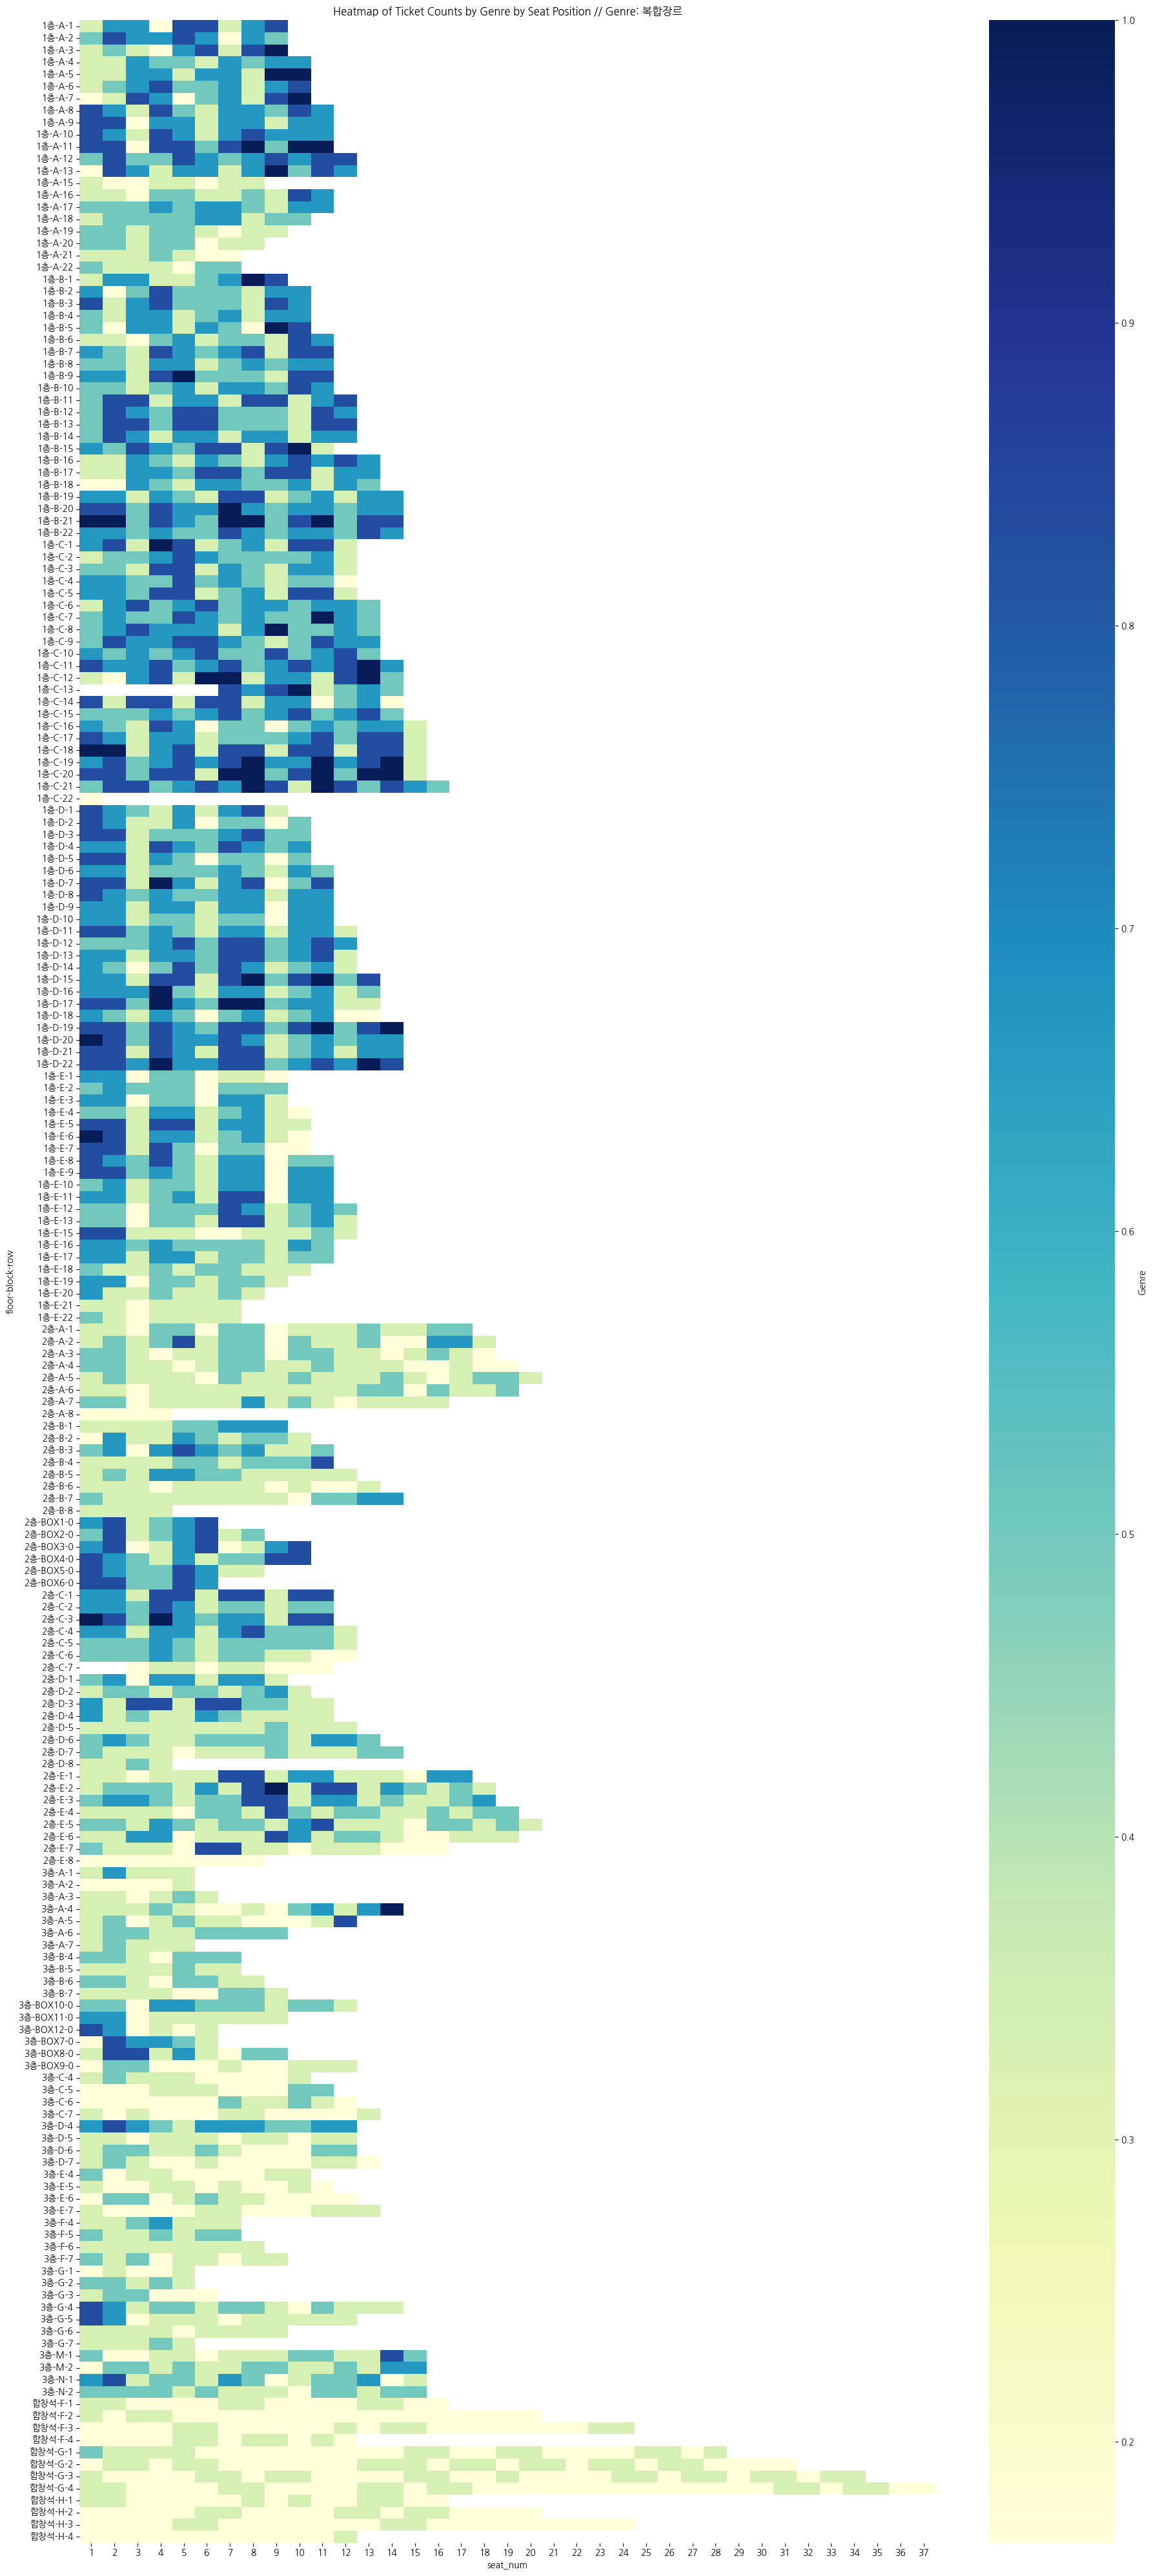

In [18]:
genres = list(data['genre'].unique())

for genre in genres:
    grouped_data_gen = data[data['genre']==genre].groupby(['floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
    heatmap_data_gen = grouped_data_gen.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='key')

    unique = data[data['genre']==genre]['new_code'].nunique()
    heatmap_data_gen /= unique

    fig, ax = plt.subplots(figsize=(18,40))

    sns.heatmap(heatmap_data_gen, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Genre'})
    ax.set_title(f'Heatmap of Ticket Counts by Genre by Seat Position // Genre: {genre}')

    plt.tight_layout()
    plt.show()



In [19]:
data[data['genre']=='복합장르']['play_date'].unique()

array(['2022-07-08', '2022-02-27', '2021-07-31', '2021-05-21',
       '2021-05-22', '2022-12-09'], dtype=object)

        howfastyoubuy

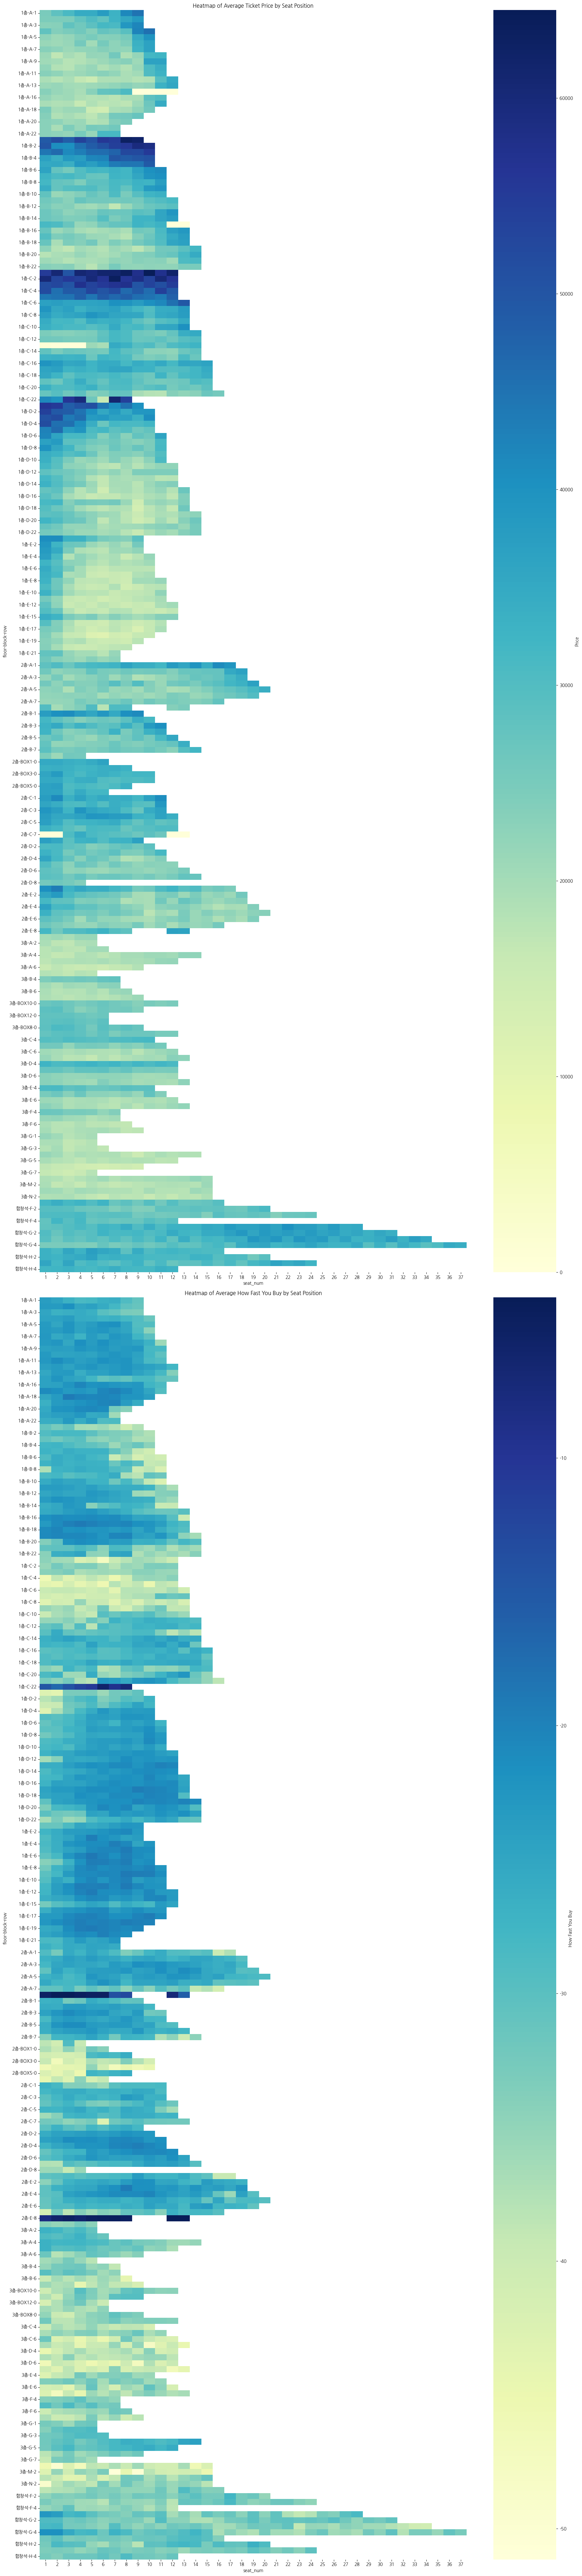

In [22]:
import seaborn as sns

# Since the data is quite large, for visualization purposes, we can take an average of price and howfastyoubuy for each unique seat position
grouped_data_price = df.groupby(['floor', 'block', 'row', 'seat_num'])['price'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_howfast = df.groupby(['floor', 'block', 'row', 'seat_num'])['howfastyoubuy'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# Pivot the data for heatmap visualization
heatmap_data_howfast = grouped_data_howfast.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='howfastyoubuy')

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(18, 80))
# fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=axes[0], cmap="YlGnBu", cbar_kws={'label': 'Price'})
axes[0].set_title('Heatmap of Average Ticket Price by Seat Position')

# sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Price'})
# ax.set_title('Heatmap of Average Ticket Price by Seat Position')

sns.heatmap(heatmap_data_howfast, ax=axes[1], cmap="YlGnBu", cbar_kws={'label': 'How Fast You Buy'})
axes[1].set_title('Heatmap of Average How Fast You Buy by Seat Position')

plt.tight_layout()
plt.show()


In [23]:
data.groupby(['floor', 'block', 'row', 'seat_num'])['involvement'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

floor block  row  seat_num  involvement
0       1층     A    1         1     0.988417
1       1층     A    1         2     1.035433
2       1층     A    1         3     1.247588
3       1층     A    1         4     1.214286
4       1층     A    1         5     1.322259
...    ...   ...  ...       ...          ...
2504   합창석     H    4         8     1.935714
2505   합창석     H    4         9     1.807018
2506   합창석     H    4        10     1.857143
2507   합창석     H    4        11     1.931298
2508   합창석     H    4        12     2.037975

[2509 rows x 5 columns]

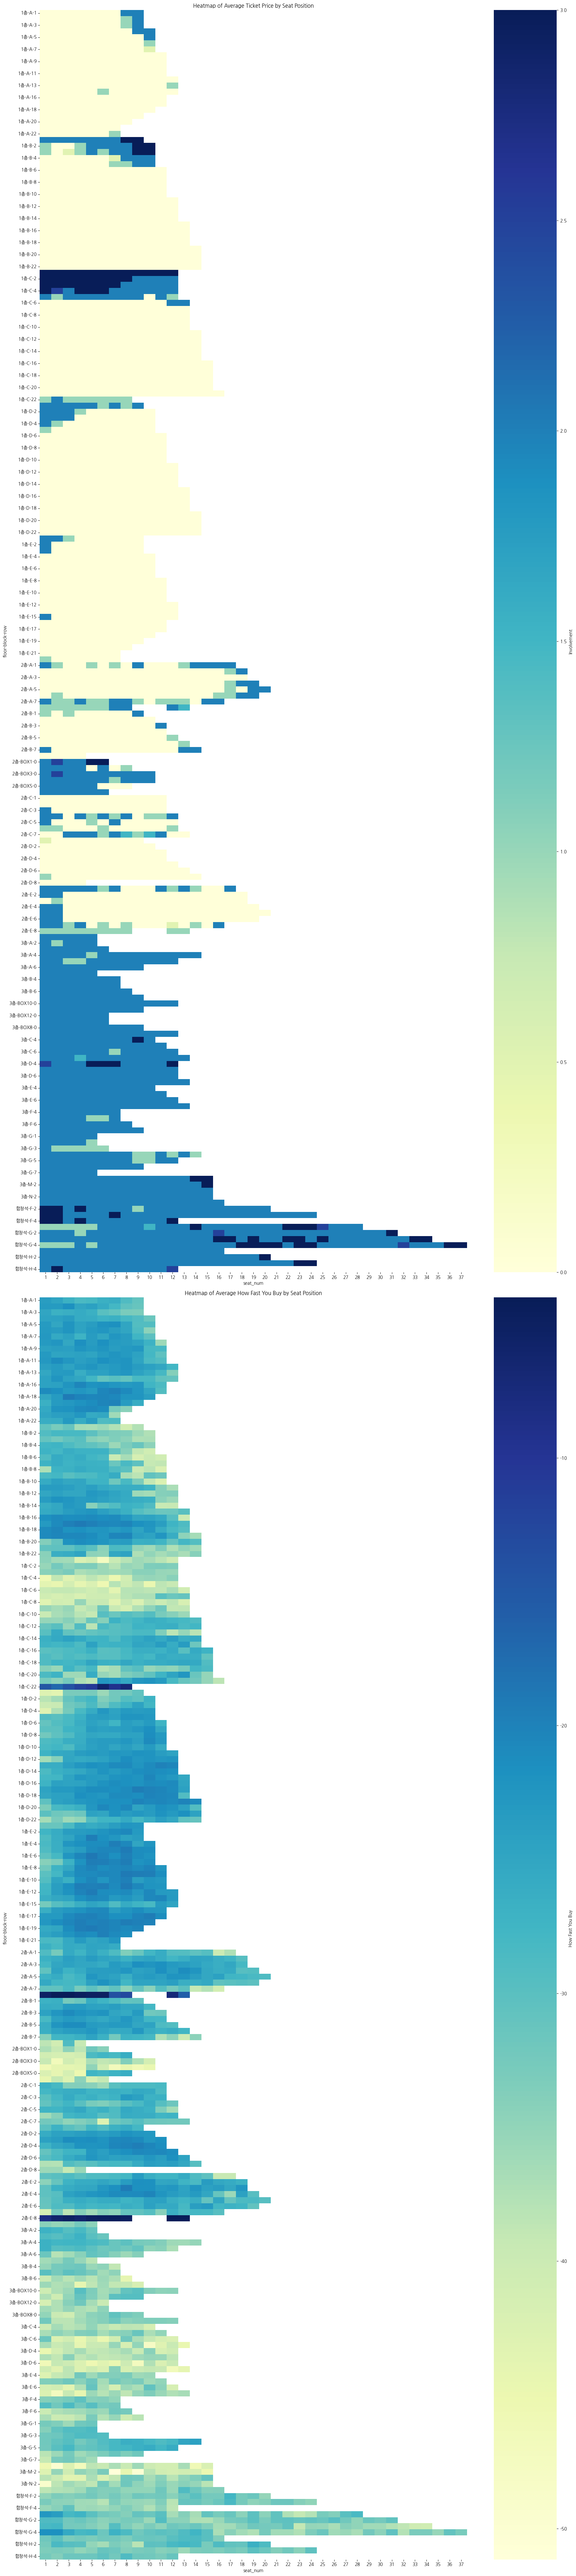

In [24]:
import seaborn as sns

# Since the data is quite large, for visualization purposes, we can take an average of price and howfastyoubuy for each unique seat position
grouped_data_inv = df.groupby(['floor', 'block', 'row', 'seat_num'])['involvement'].median().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_howfast = data.groupby(['floor', 'block', 'row', 'seat_num'])['howfastyoubuy'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# Pivot the data for heatmap visualization
heatmap_data_inv = grouped_data_inv.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='involvement')
heatmap_data_howfast = grouped_data_howfast.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='howfastyoubuy')

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(18, 80))

sns.heatmap(heatmap_data_inv, ax=axes[0], cmap="YlGnBu", cbar_kws={'label': 'Involvement'})
axes[0].set_title('Heatmap of Average Ticket Price by Seat Position')

sns.heatmap(heatmap_data_howfast, ax=axes[1], cmap="YlGnBu", cbar_kws={'label': 'How Fast You Buy'})
axes[1].set_title('Heatmap of Average How Fast You Buy by Seat Position')

plt.tight_layout()
plt.show()


        running time

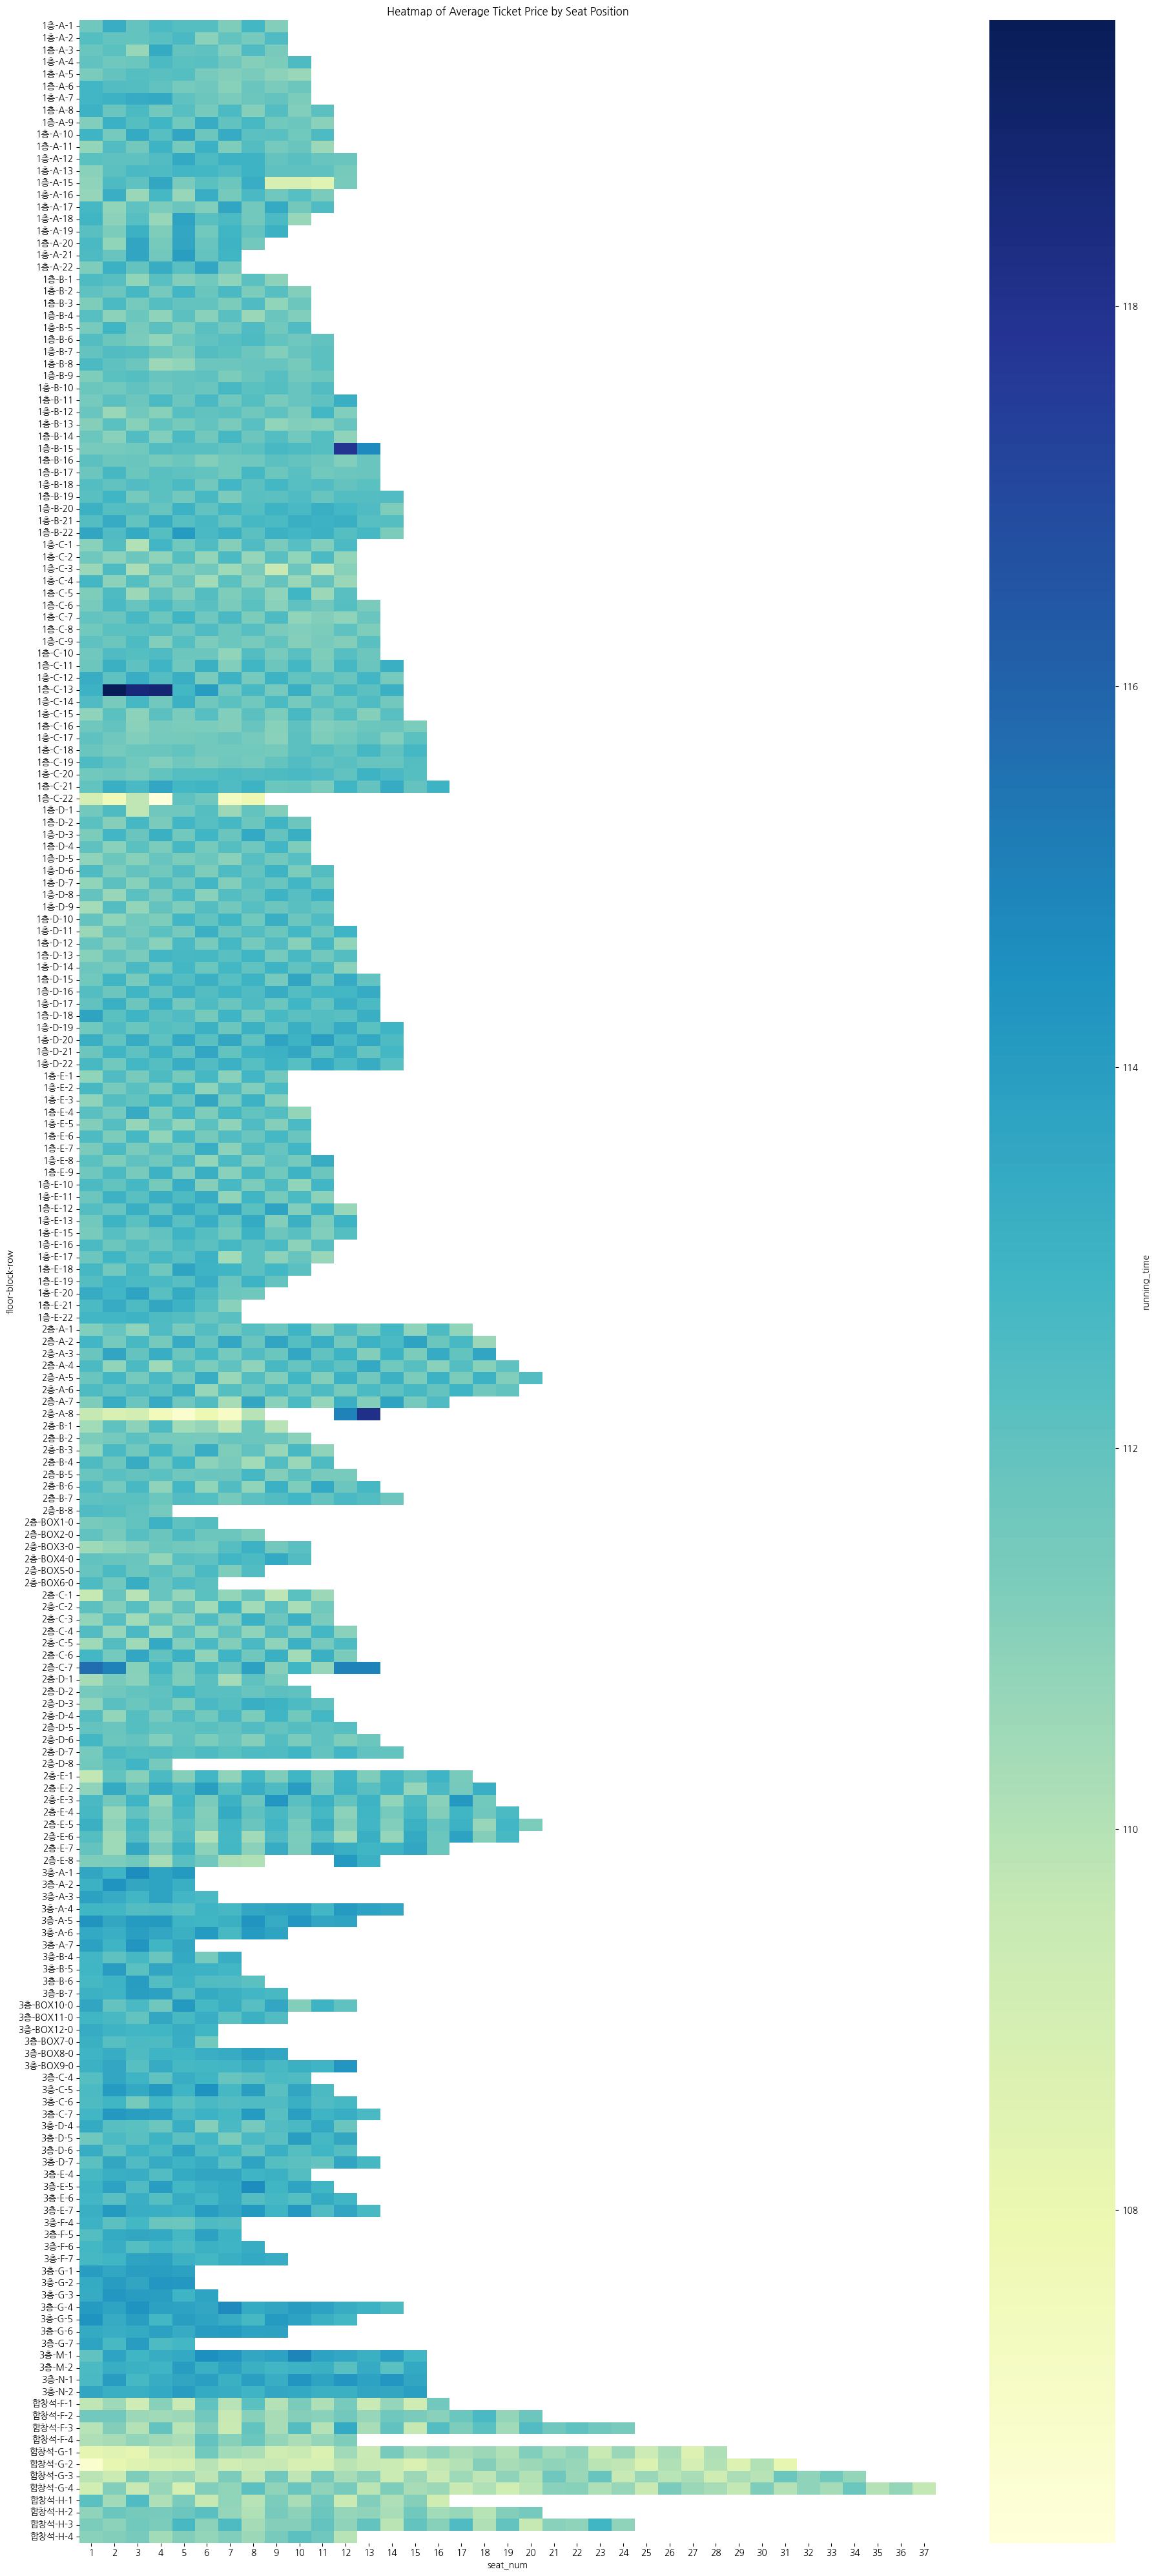

In [21]:
# 데이터 추출
grouped_data_price = df.groupby(['floor', 'block', 'row', 'seat_num'])['running_time'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_price = grouped_data_price.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='running_time')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'running_time'})
ax.set_title('Heatmap of Average Ticket Price by Seat Position')

plt.tight_layout()
plt.show()

        ticket_cancel

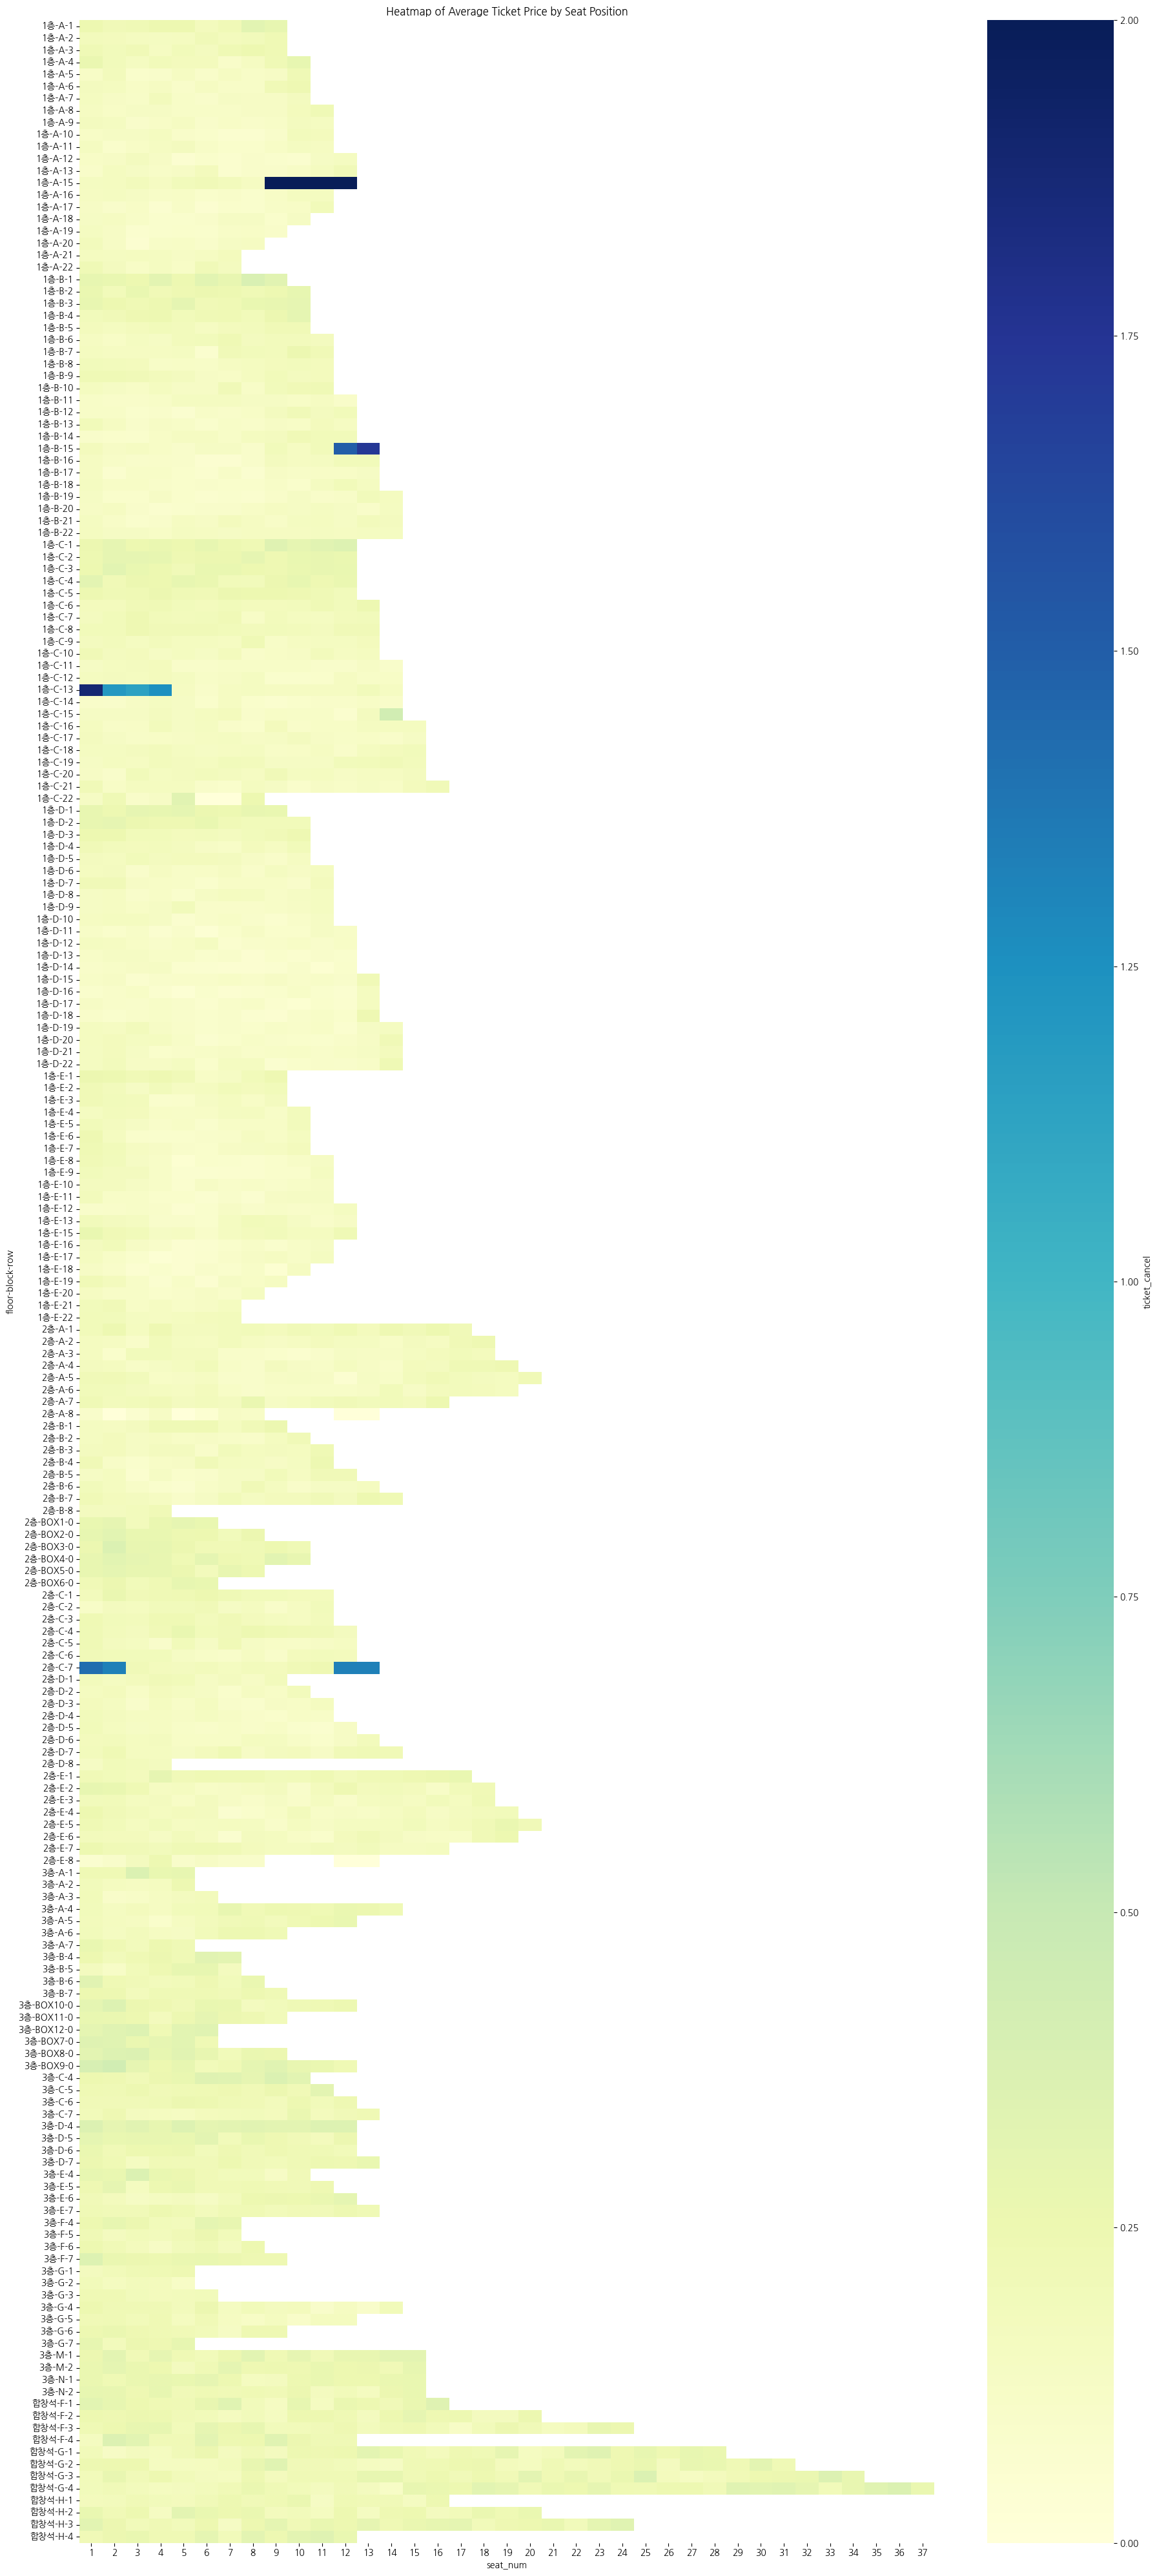

In [25]:
# 데이터 추출
grouped_data_price = df.groupby(['floor', 'block', 'row', 'seat_num'])['ticket_cancel'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_price = grouped_data_price.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='ticket_cancel')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'ticket_cancel'})
ax.set_title('Heatmap of Average Ticket Price by Seat Position')

plt.tight_layout()
plt.show()

        running time

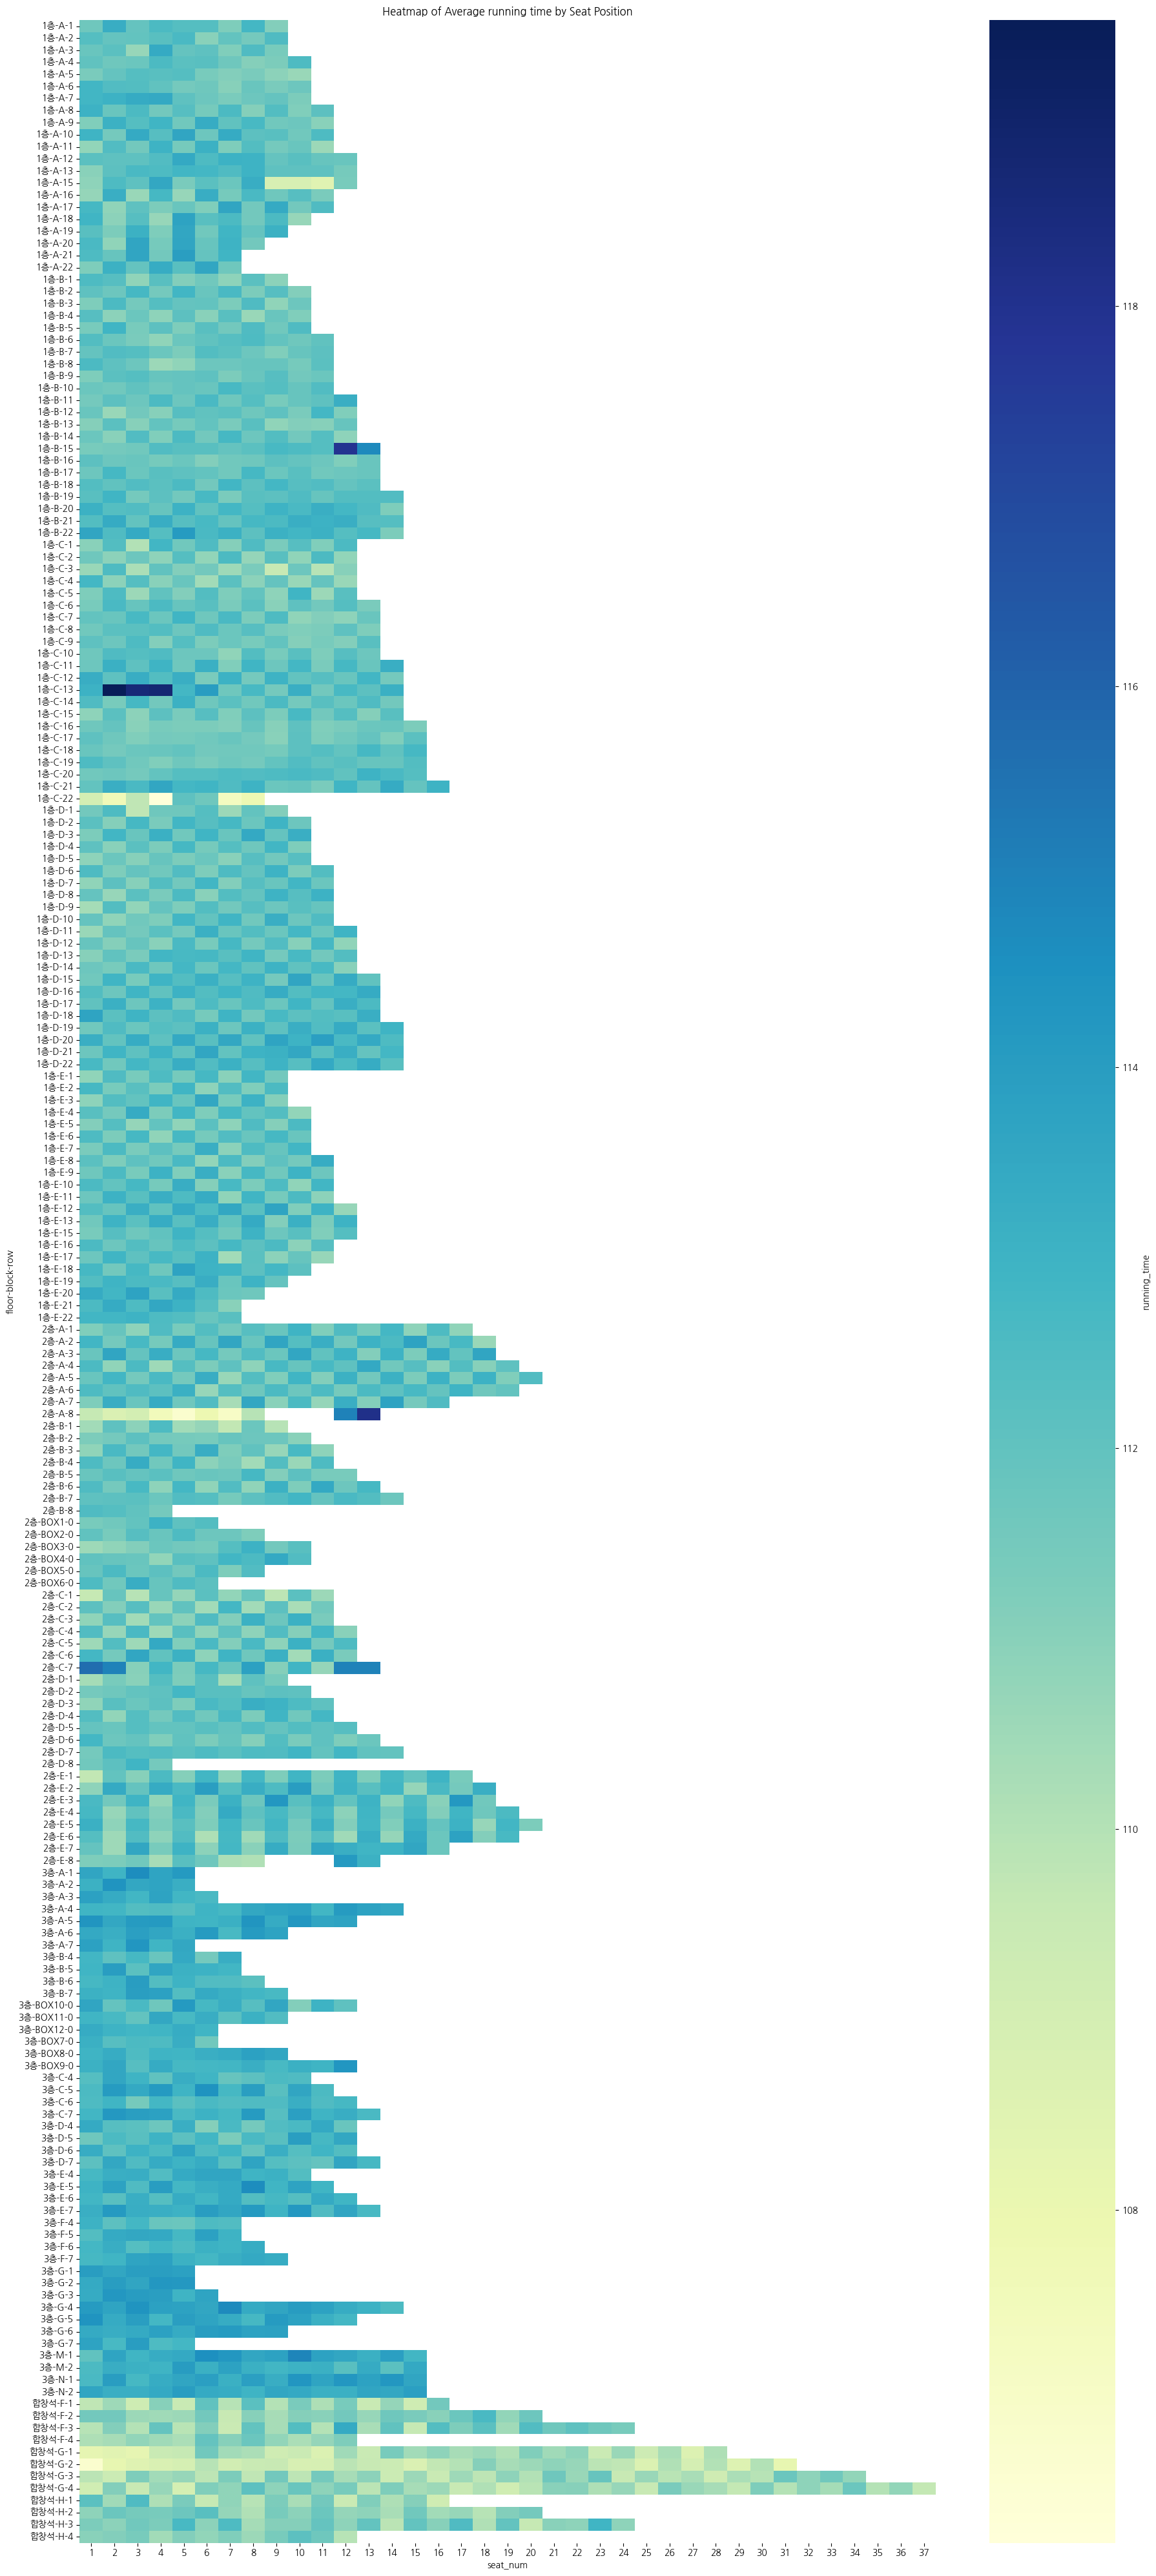

In [26]:
# 데이터 추출
grouped_data_price = df.groupby(['floor', 'block', 'row', 'seat_num'])['running_time'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_price = grouped_data_price.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='running_time')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'running_time'})
ax.set_title('Heatmap of Average running time by Seat Position')

plt.tight_layout()
plt.show()

                all_mem_cnt

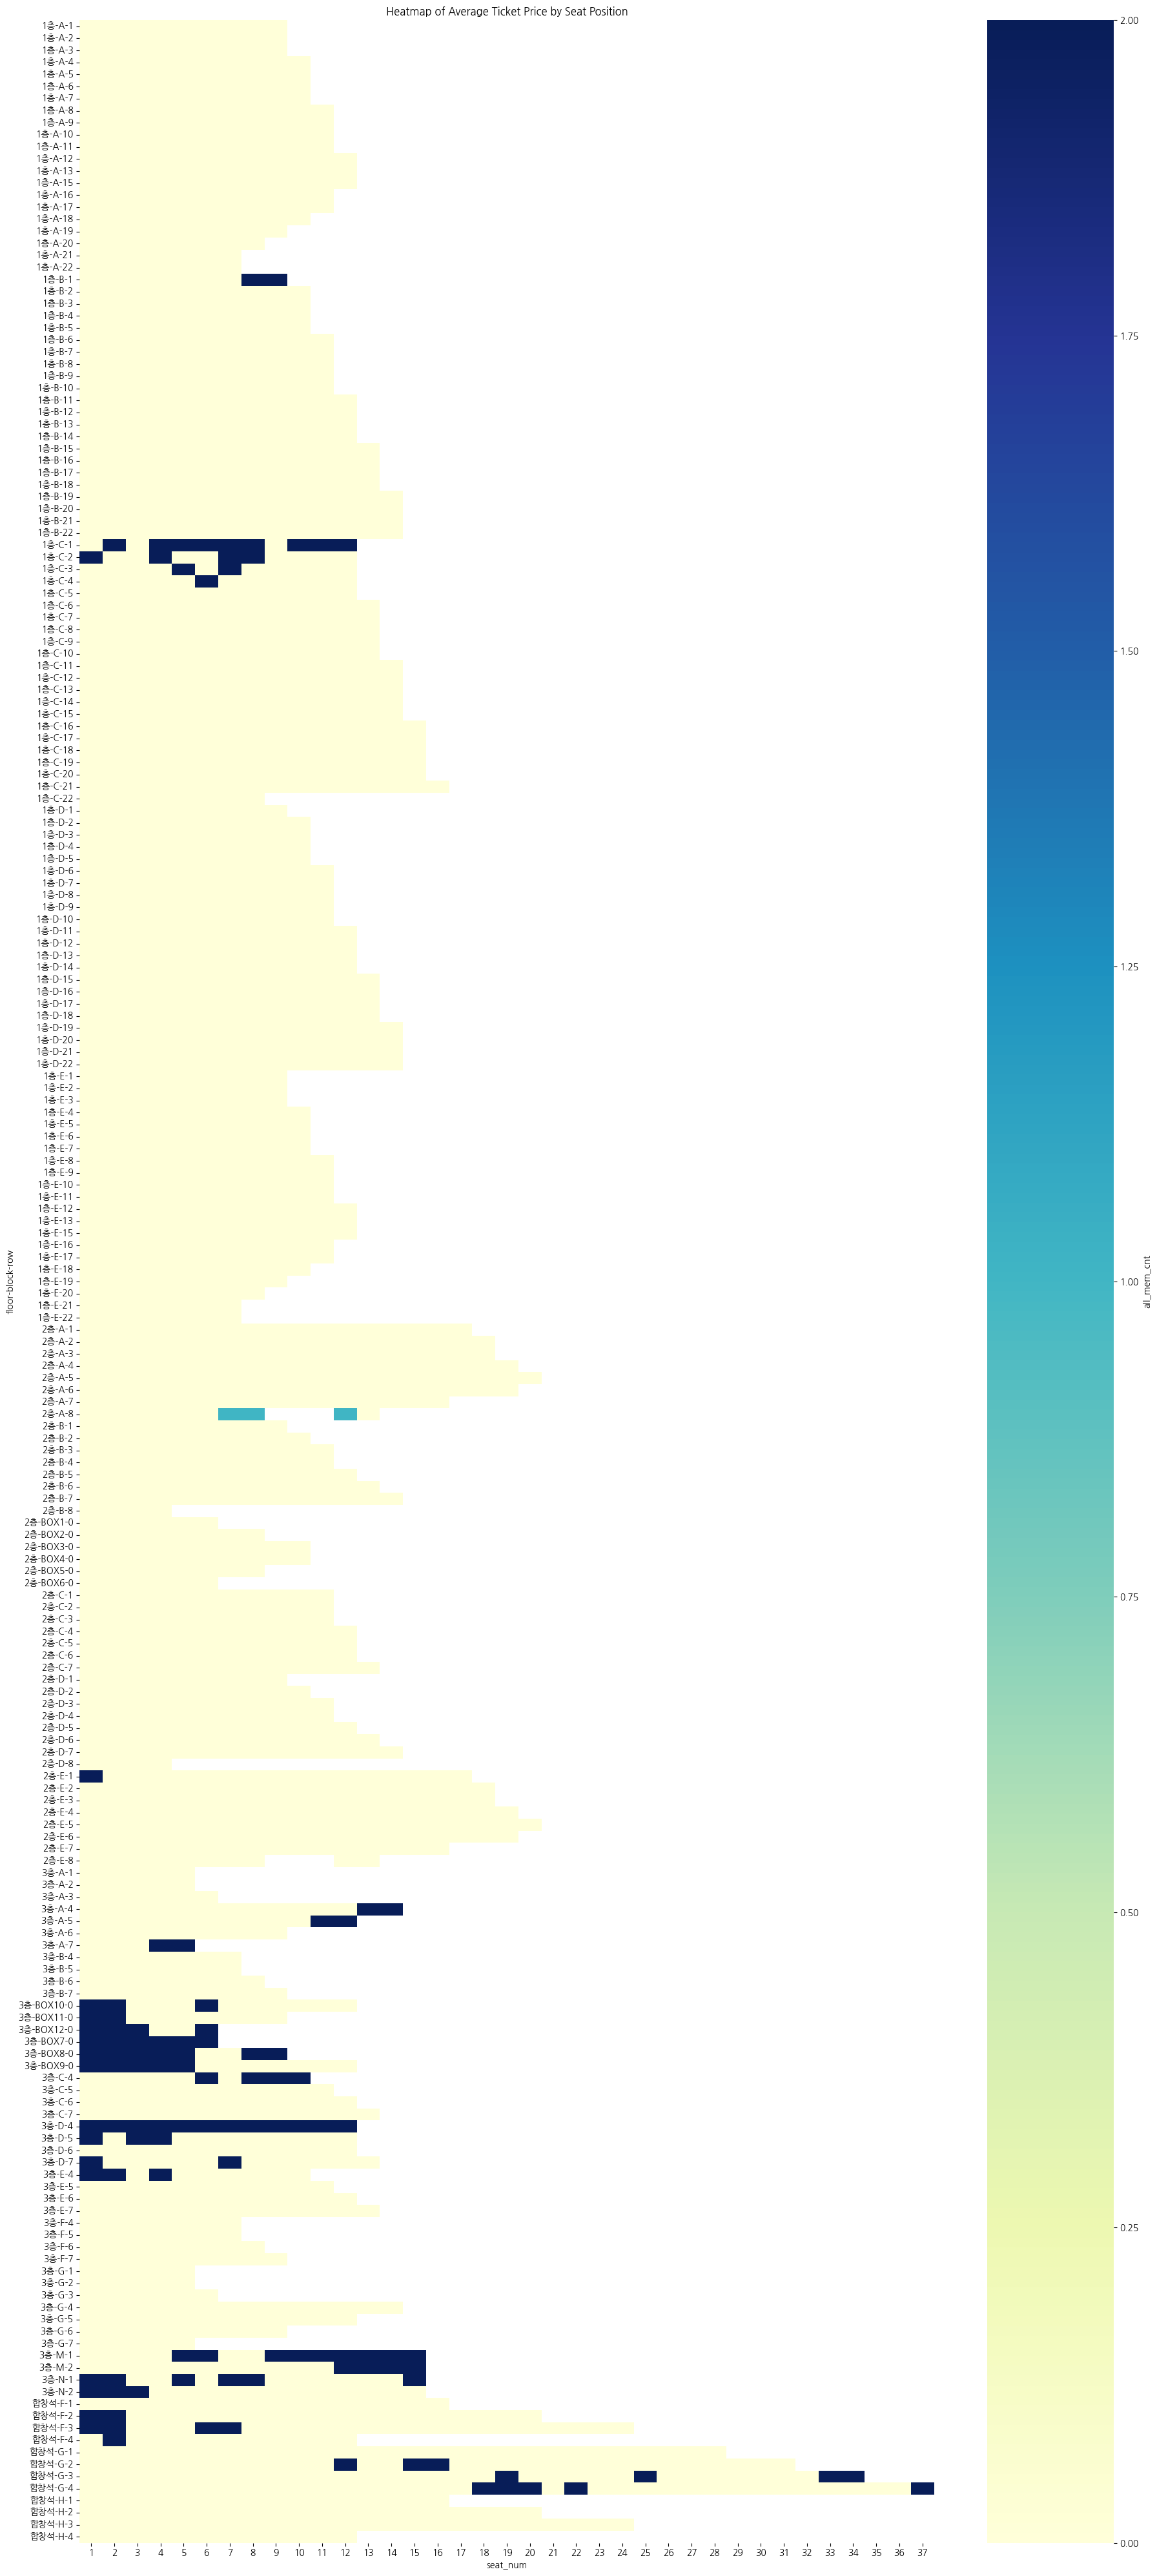

In [31]:
# 데이터 추출
grouped_data_price = df.groupby(['floor', 'block', 'row', 'seat_num'])['all_mem_cnt'].apply(lambda x: x.mode().iloc[0] if not x.empty else None).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_price = grouped_data_price.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='all_mem_cnt')
# 시각화

fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'all_mem_cnt'})
ax.set_title('Heatmap of Average Ticket Price by Seat Position')

plt.tight_layout()
plt.show()

        discount_cat

In [38]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 생성
label_encoder = LabelEncoder()

df_encoded =df.copy()

encoder_dict = {}

# 각 열에 대해 LabelEncoder 적용
encoder = LabelEncoder()
df_encoded['discount_cat'] = encoder.fit_transform(df['discount_cat'])
encoder_dict['discount_cat'] = encoder.classes_
encoder_dict

{'discount_cat': array(['가족', '공연', '국가', '기업 및 관계자', '기타 및 이벤트', '노인', '예술의 전당', '일반',
        '학생'], dtype=object)}

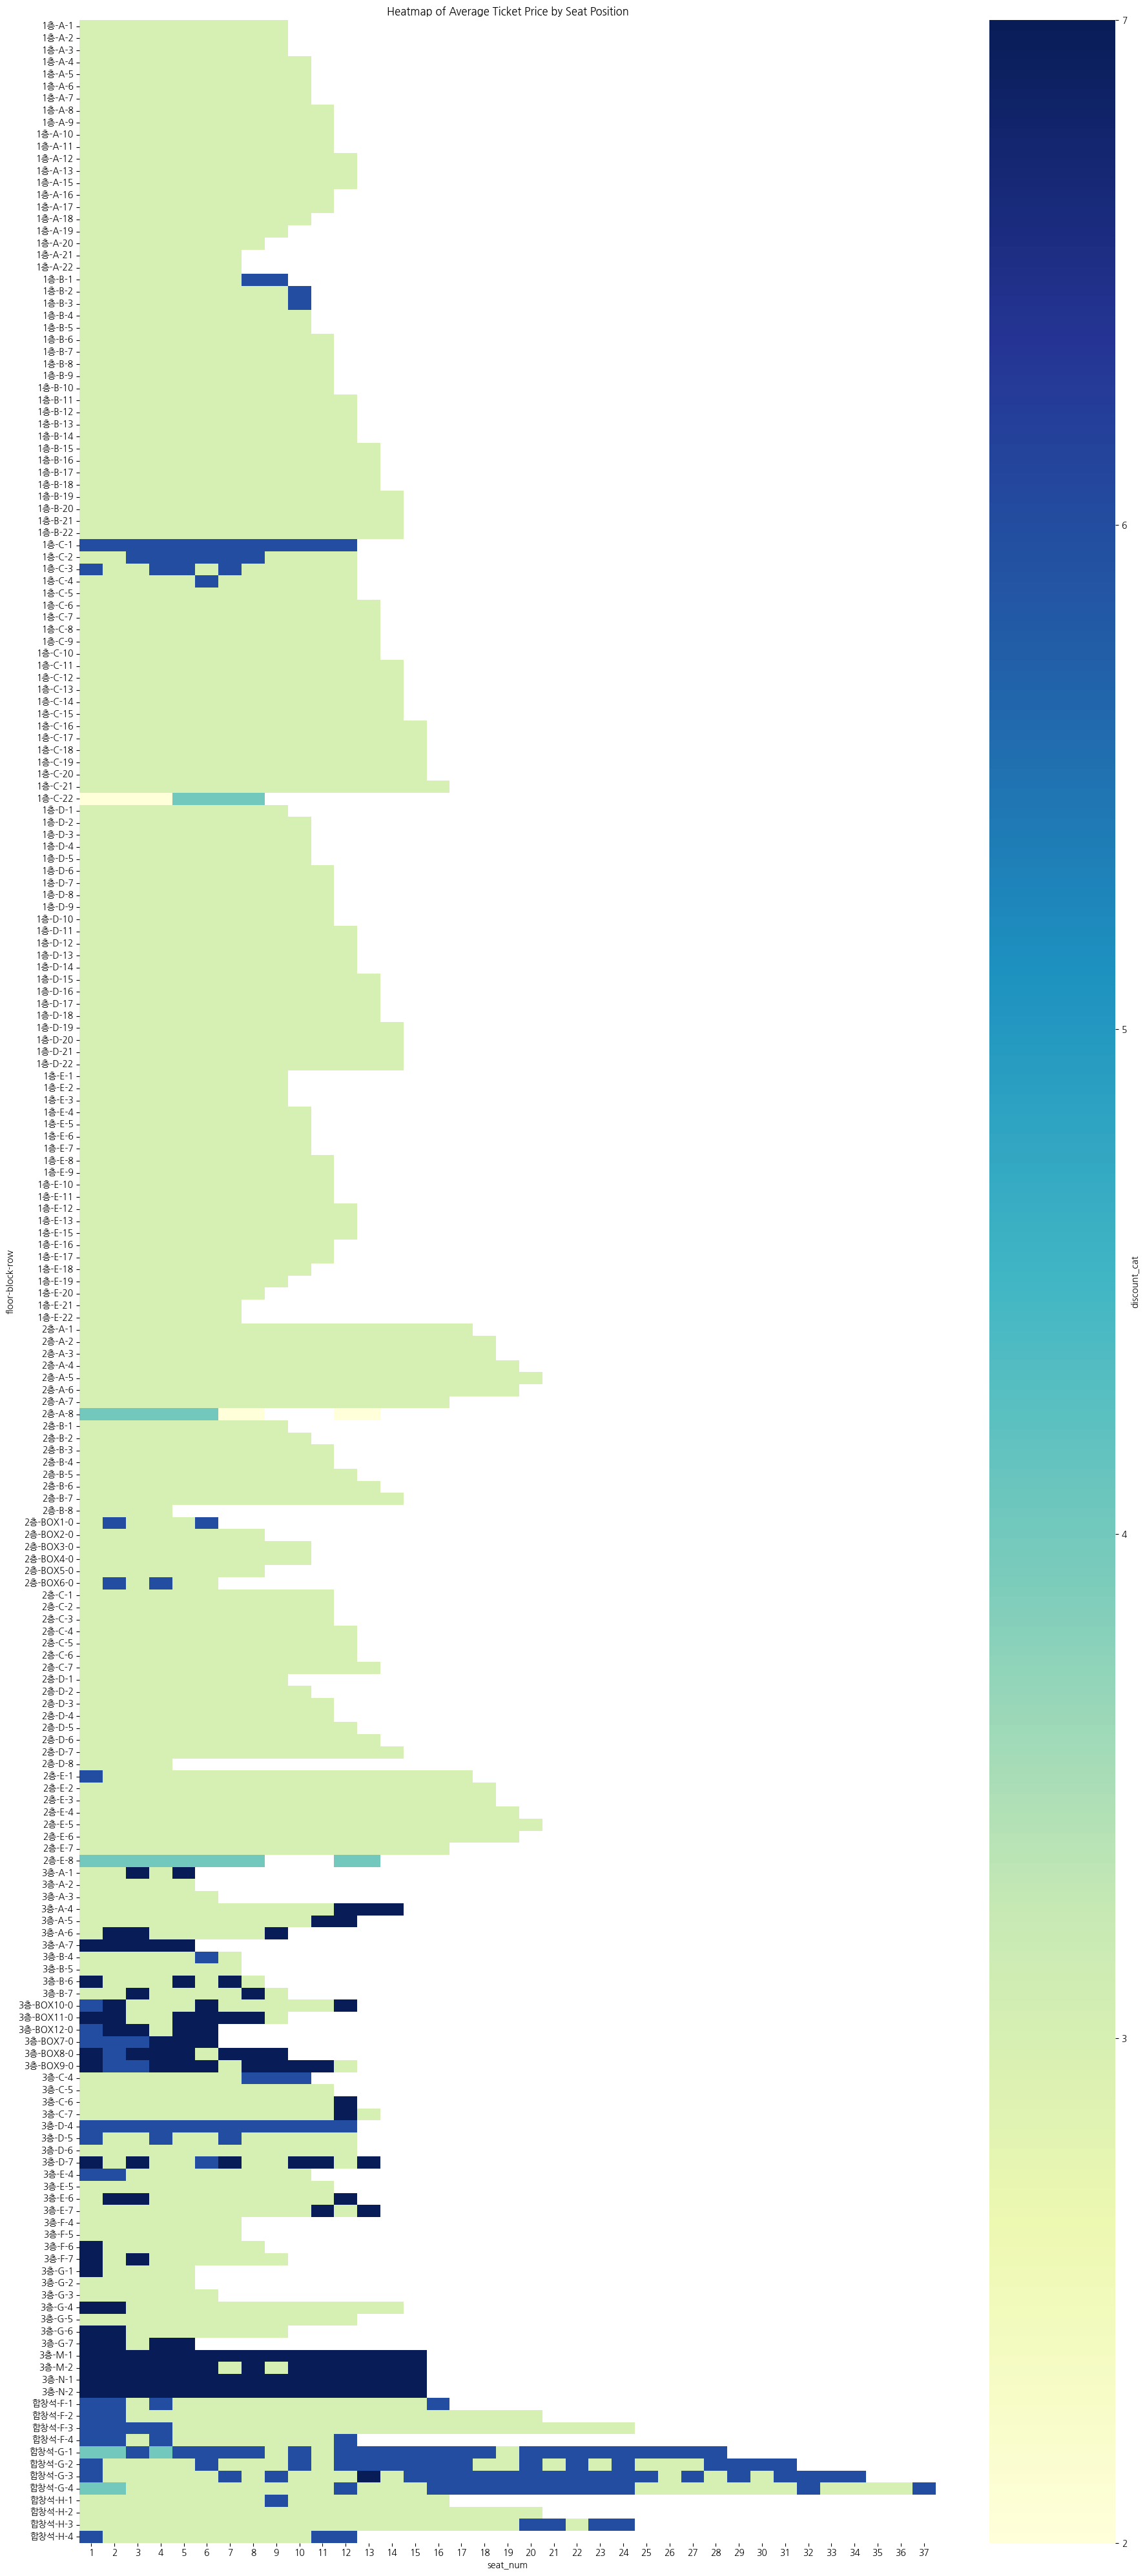

In [39]:
# mode

# 데이터 추출
grouped_data_price = df_encoded.groupby(['floor', 'block', 'row', 'seat_num'])['discount_cat'].apply(lambda x: x.mode().iloc[0] if not x.empty else None).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_price = grouped_data_price.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='discount_cat')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'discount_cat'})
ax.set_title('Heatmap of Average Ticket Price by Seat Position')

plt.tight_layout()
plt.show()

        performance time slot

In [44]:
df['performance_time_slot'].unique()

array(['evening', 'day', 'morning'], dtype=object)

In [45]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 생성
label_encoder = LabelEncoder()

df_encoded = df.copy()

encoder_dict = {}

# 각 열에 대해 LabelEncoder 적용
encoder = LabelEncoder()
df_encoded['performance_time_slot'] = encoder.fit_transform(df['performance_time_slot'])
encoder_dict['performance_time_slot'] = encoder.classes_
encoder_dict

{'performance_time_slot': array(['day', 'evening', 'morning'], dtype=object)}

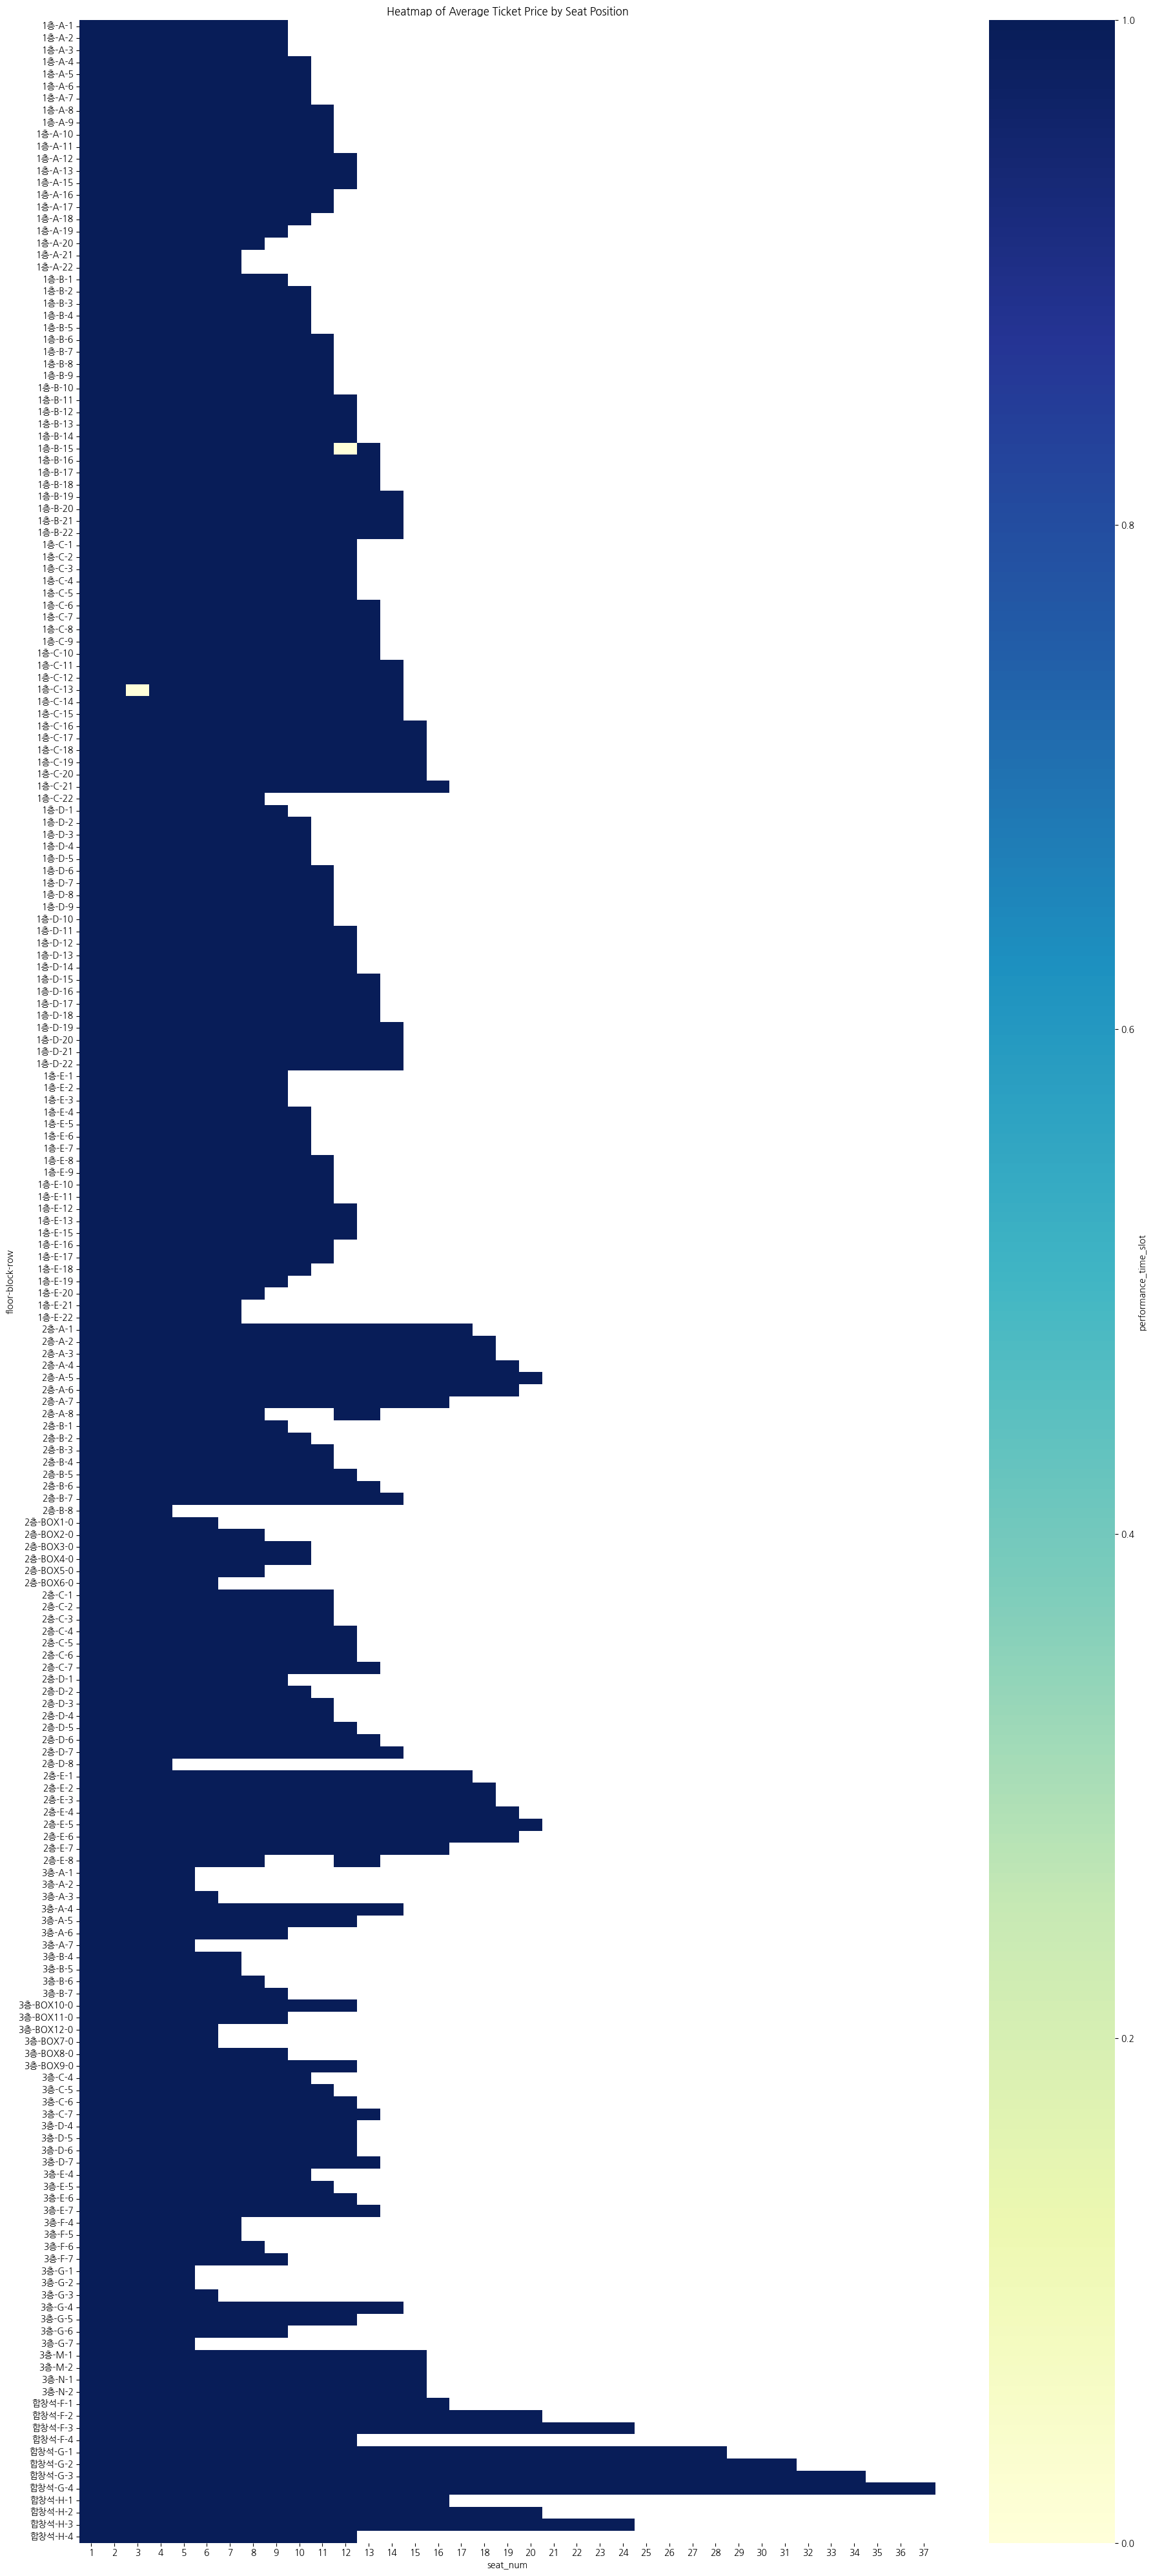

In [46]:
# mode

# 데이터 추출
grouped_data_price = df_encoded.groupby(['floor', 'block', 'row', 'seat_num'])['performance_time_slot'].apply(lambda x: x.mode().iloc[0] if not x.empty else None).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_price = grouped_data_price.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='performance_time_slot')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_price, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'performance_time_slot'})
ax.set_title('Heatmap of Average Ticket Price by Seat Position')

plt.tight_layout()
plt.show()

        weekday_or_weekend

In [9]:
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['weekday_or_weekend'] = le.fit_transform(df['weekday_or_weekend'])
# 1 weekend(주말) 0 weekday(평일)

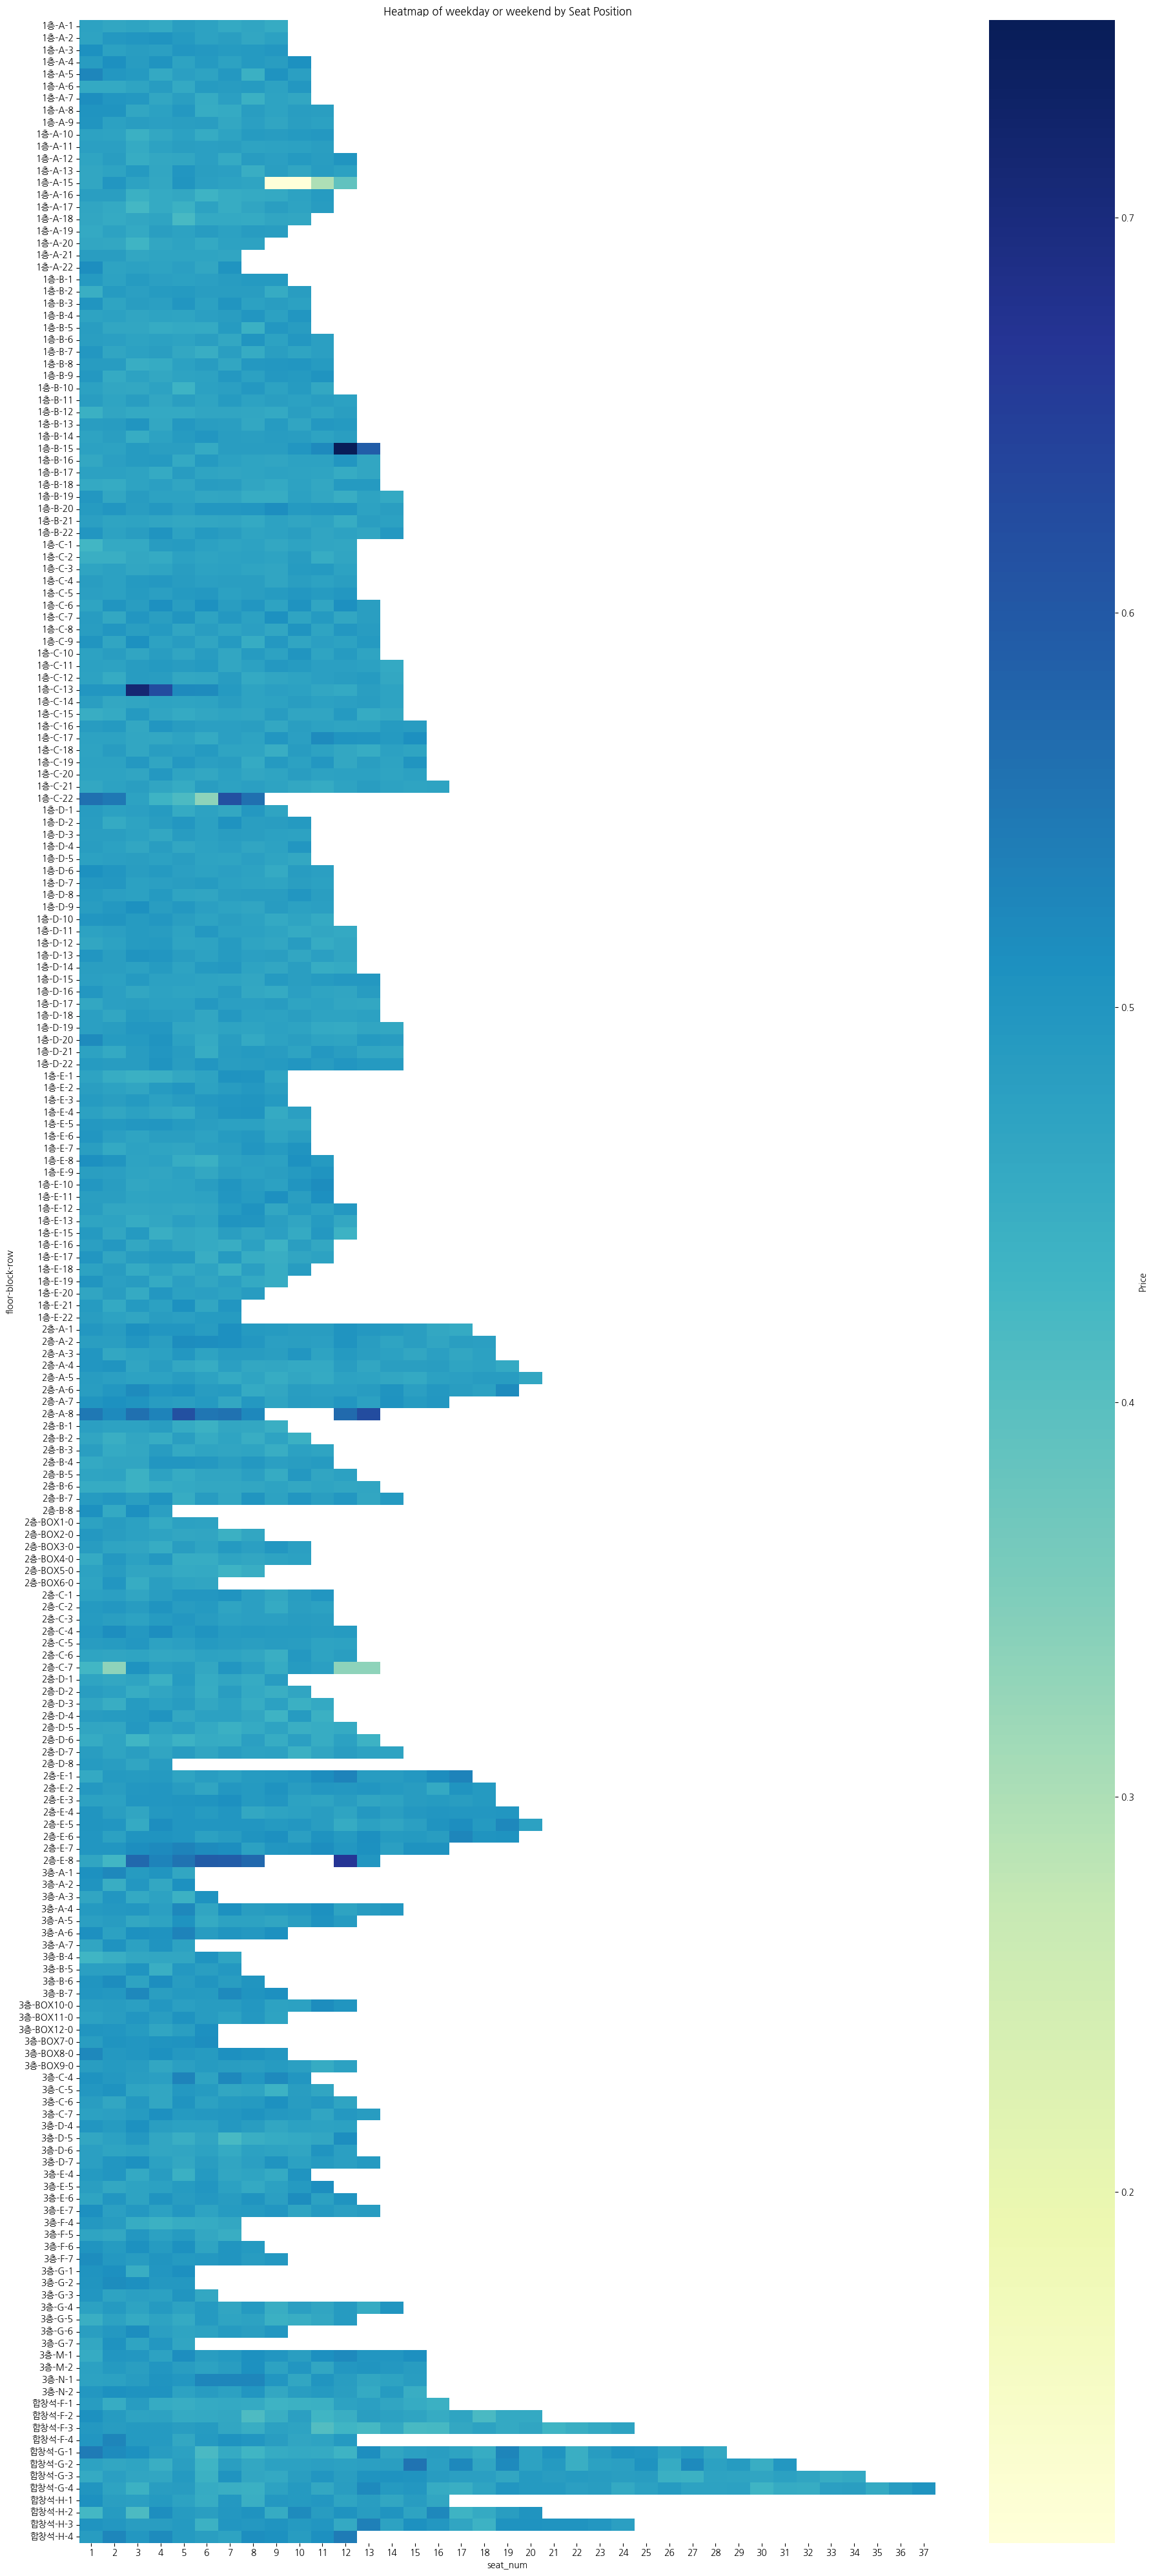

In [10]:
# 데이터 추출
grouped_data_weekday_or_weekend = df.groupby(['floor', 'block', 'row', 'seat_num'])['weekday_or_weekend'].apply(lambda x: x.mode().iloc[0] if not x.empty else None).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_weekday_or_weekend = df.groupby(['floor', 'block', 'row', 'seat_num'])['weekday_or_weekend'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_weekday_or_weekend = grouped_data_weekday_or_weekend.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='weekday_or_weekend')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_weekday_or_weekend, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Price'})
ax.set_title('Heatmap of weekday or weekend by Seat Position')


plt.tight_layout()
plt.show()

        inv2_paymem_cnt

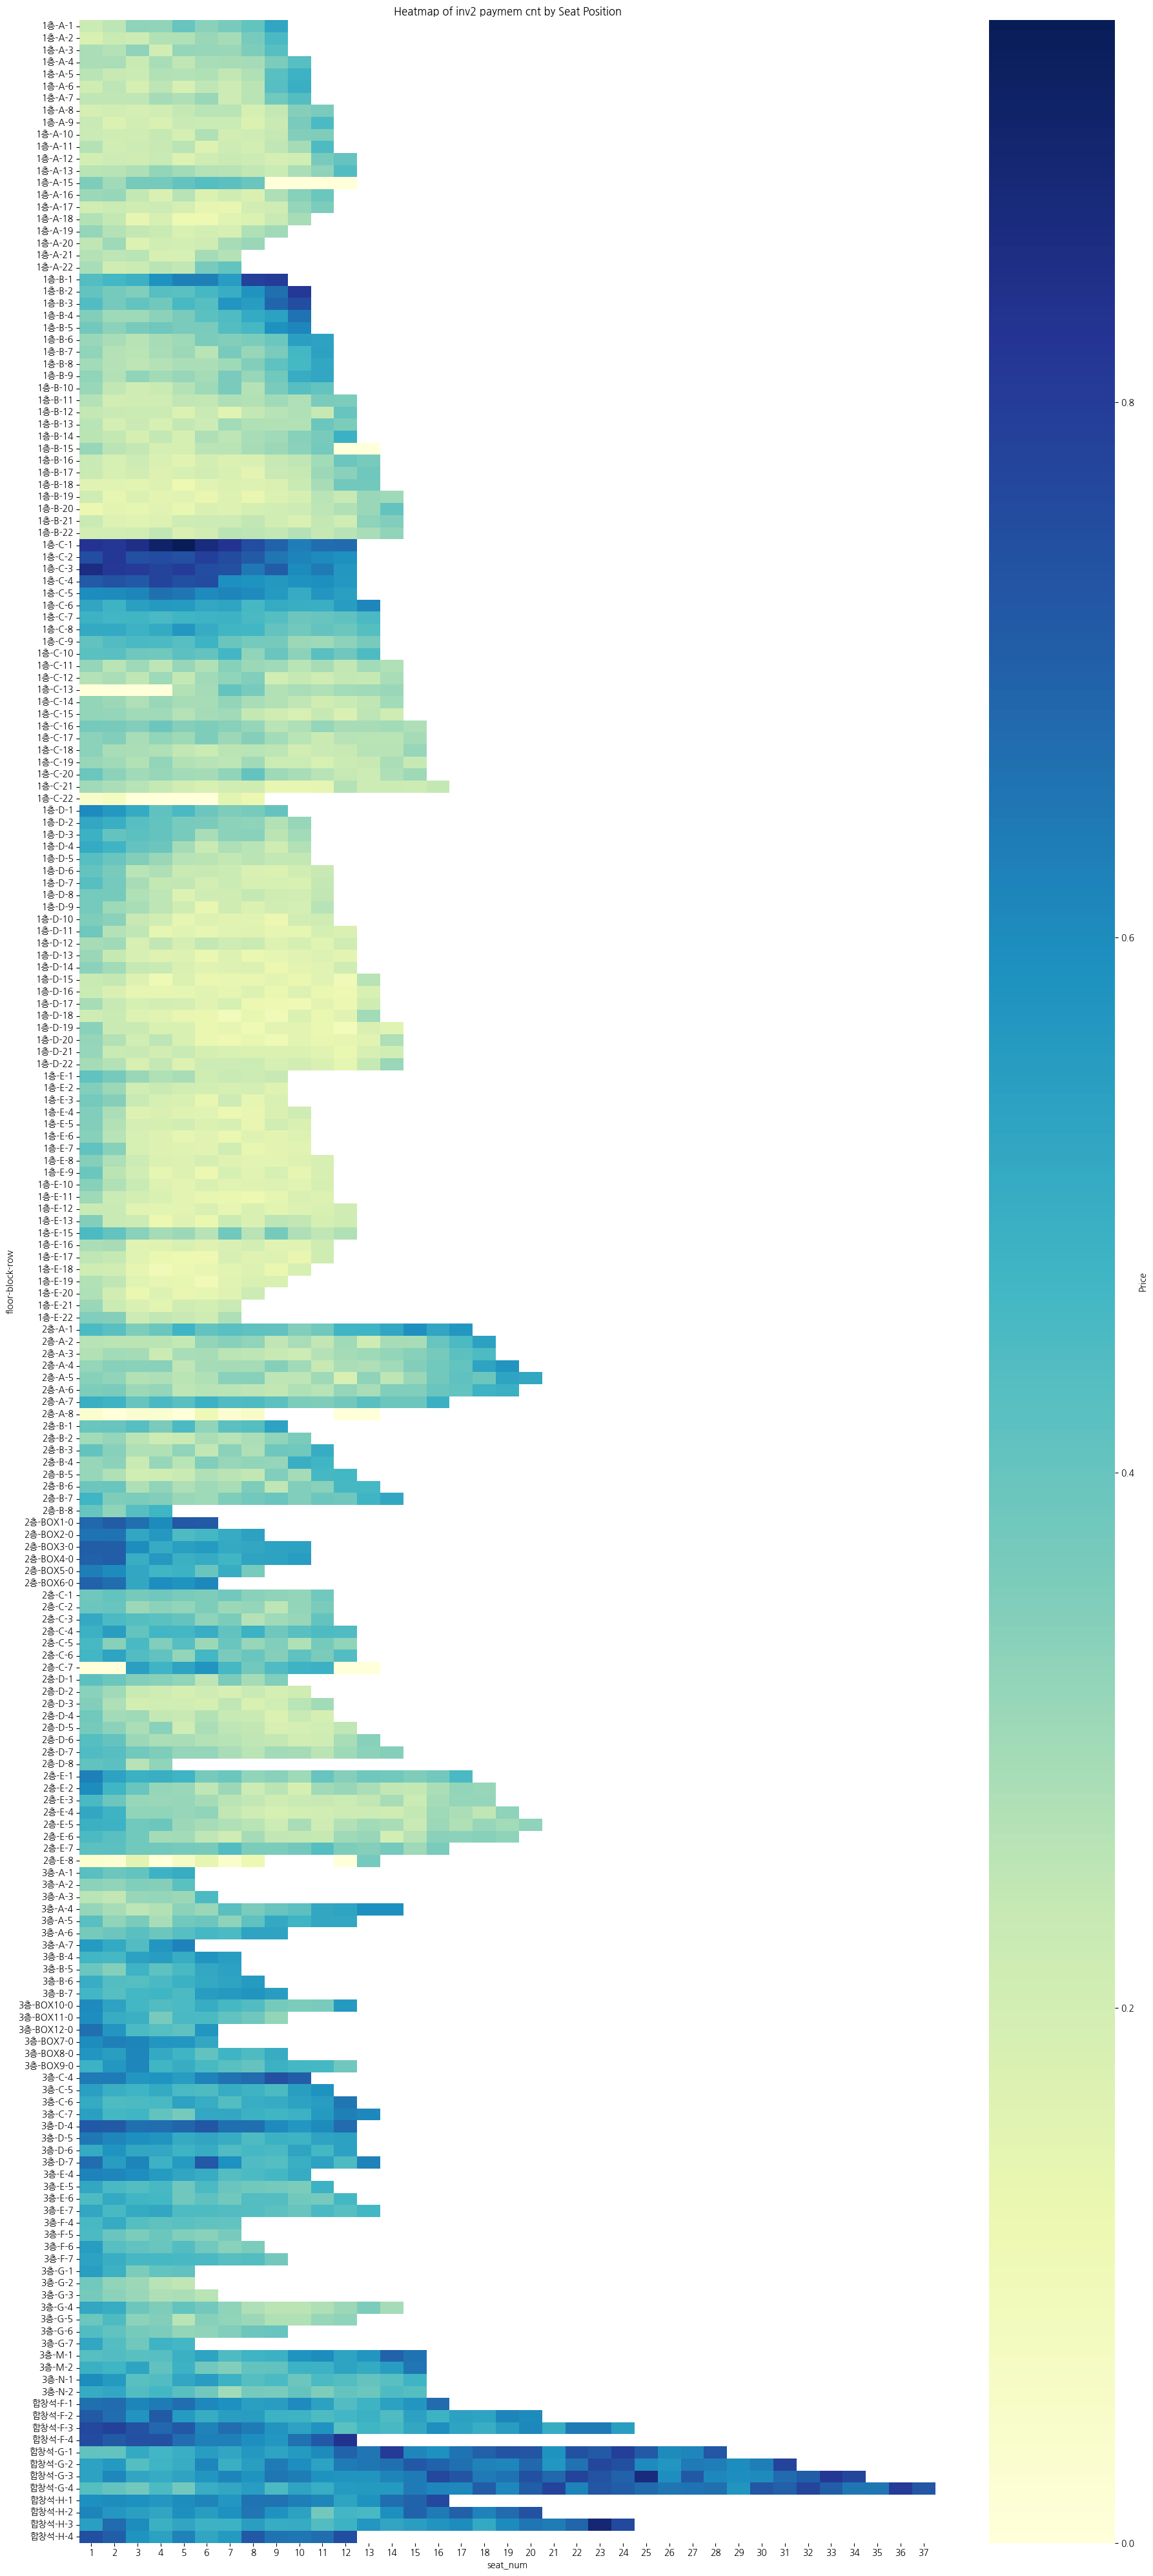

In [11]:
# 데이터 추출
grouped_data_inv2_paymem_cnt = df.groupby(['floor', 'block', 'row', 'seat_num'])['inv2_paymem_cnt'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_inv2_paymem_cnt = grouped_data_inv2_paymem_cnt.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='inv2_paymem_cnt')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_inv2_paymem_cnt, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Price'})
ax.set_title('Heatmap of inv2 paymem cnt by Seat Position')


plt.tight_layout()
plt.show()

        involvement

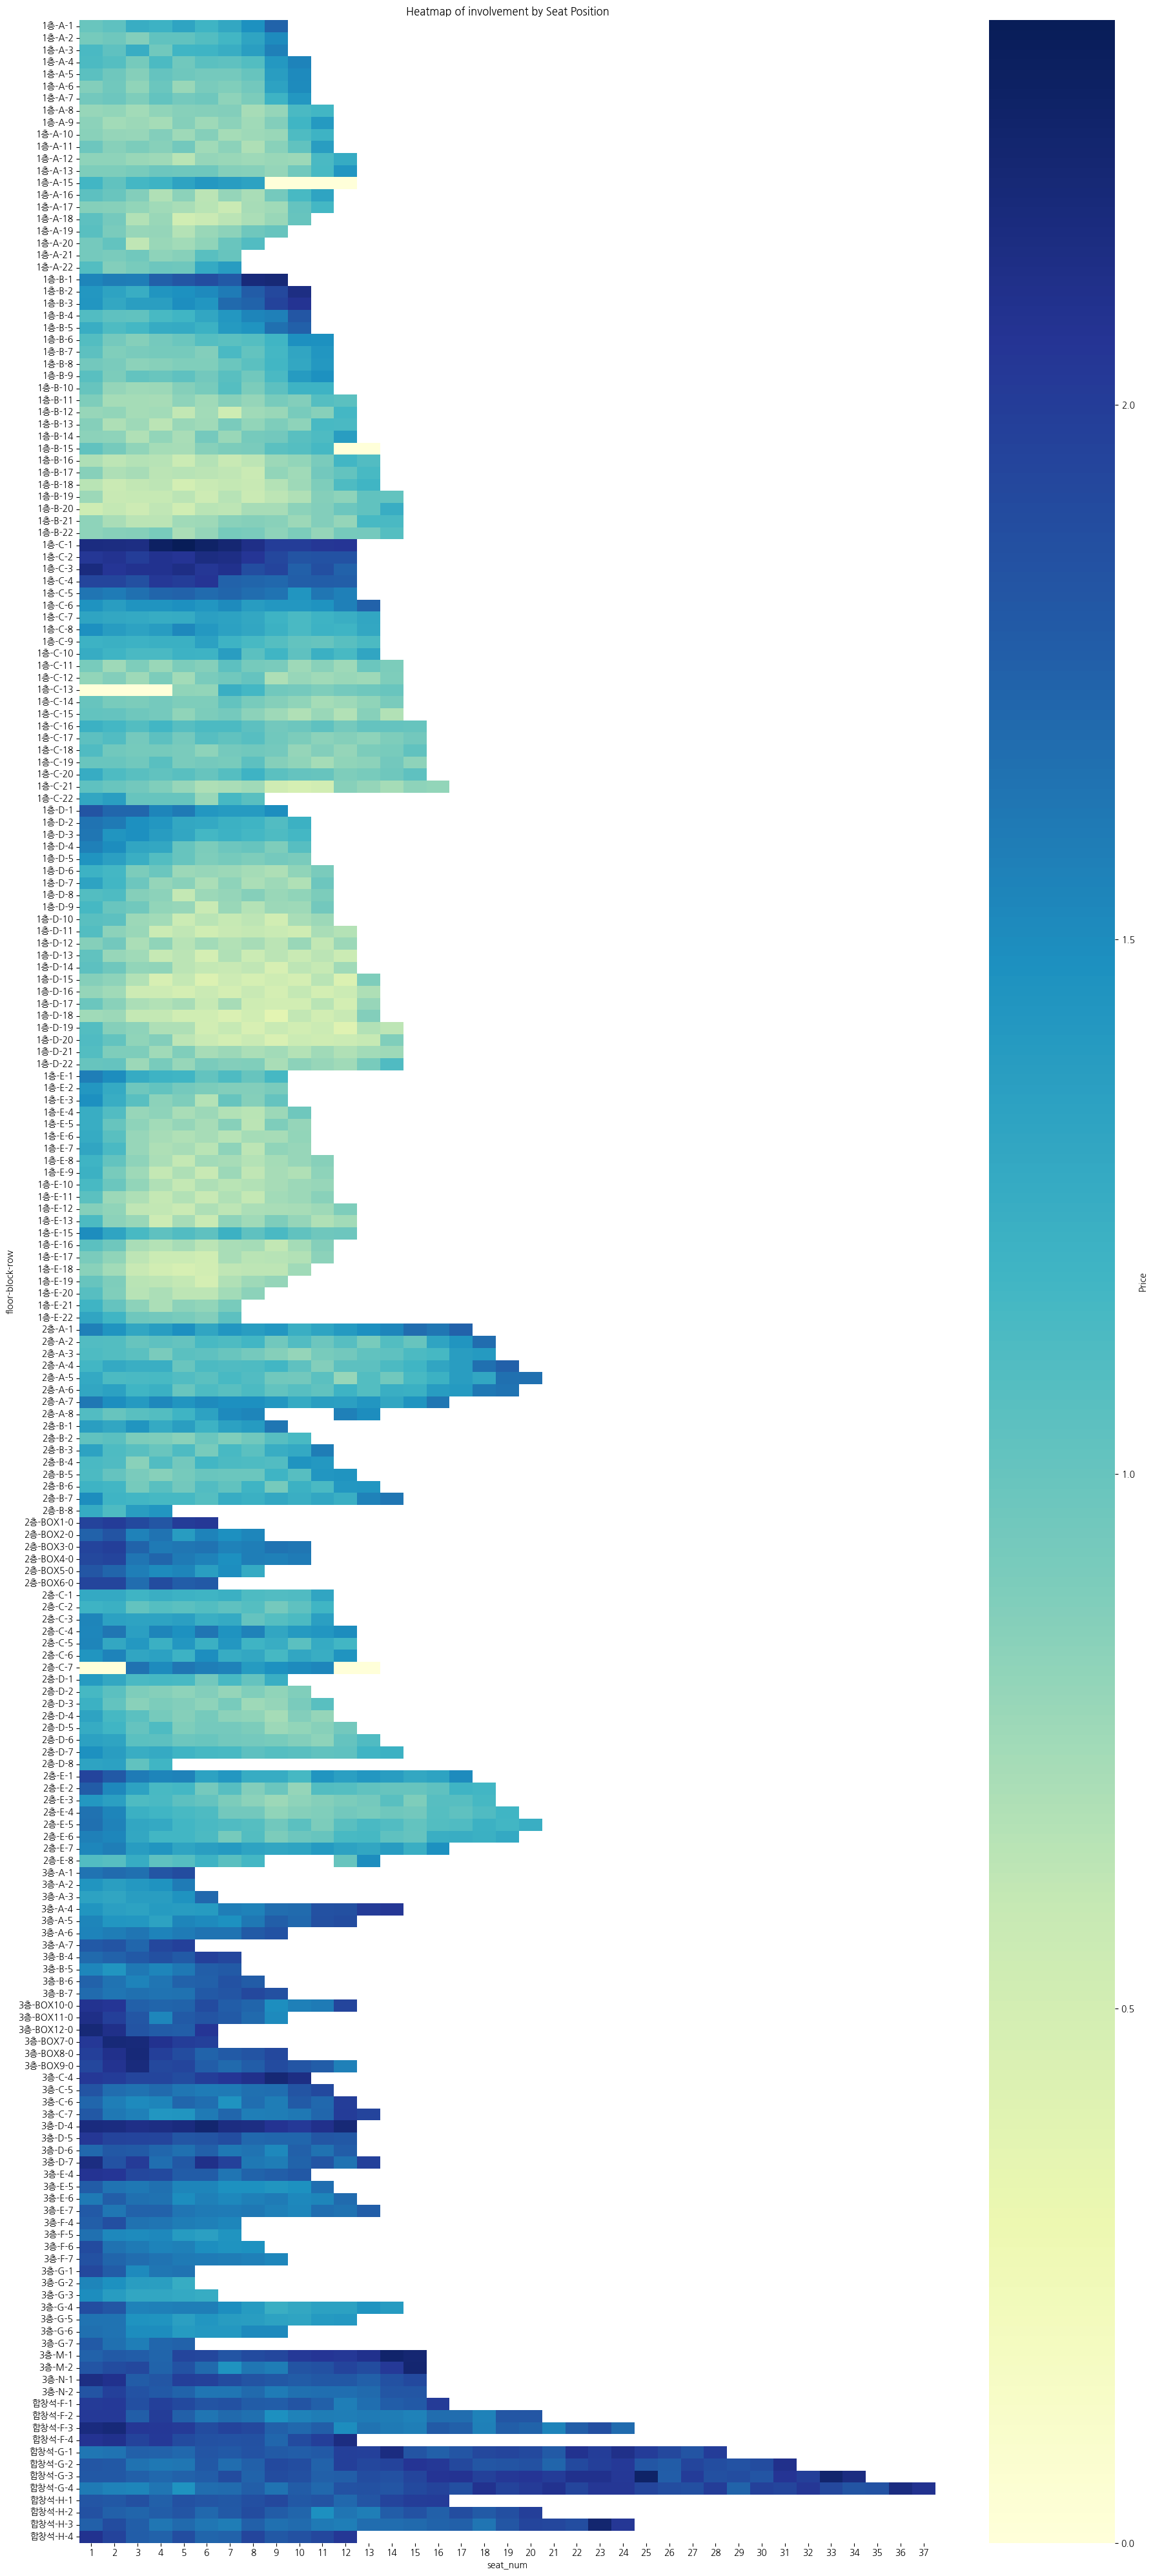

In [12]:
# 데이터 추출
grouped_data_involvement = df.groupby(['floor', 'block', 'row', 'seat_num'])['involvement'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_involvement = grouped_data_involvement.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='involvement')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_involvement, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Price'})
ax.set_title('Heatmap of involvement by Seat Position')


plt.tight_layout()
plt.show()

        discount_rate

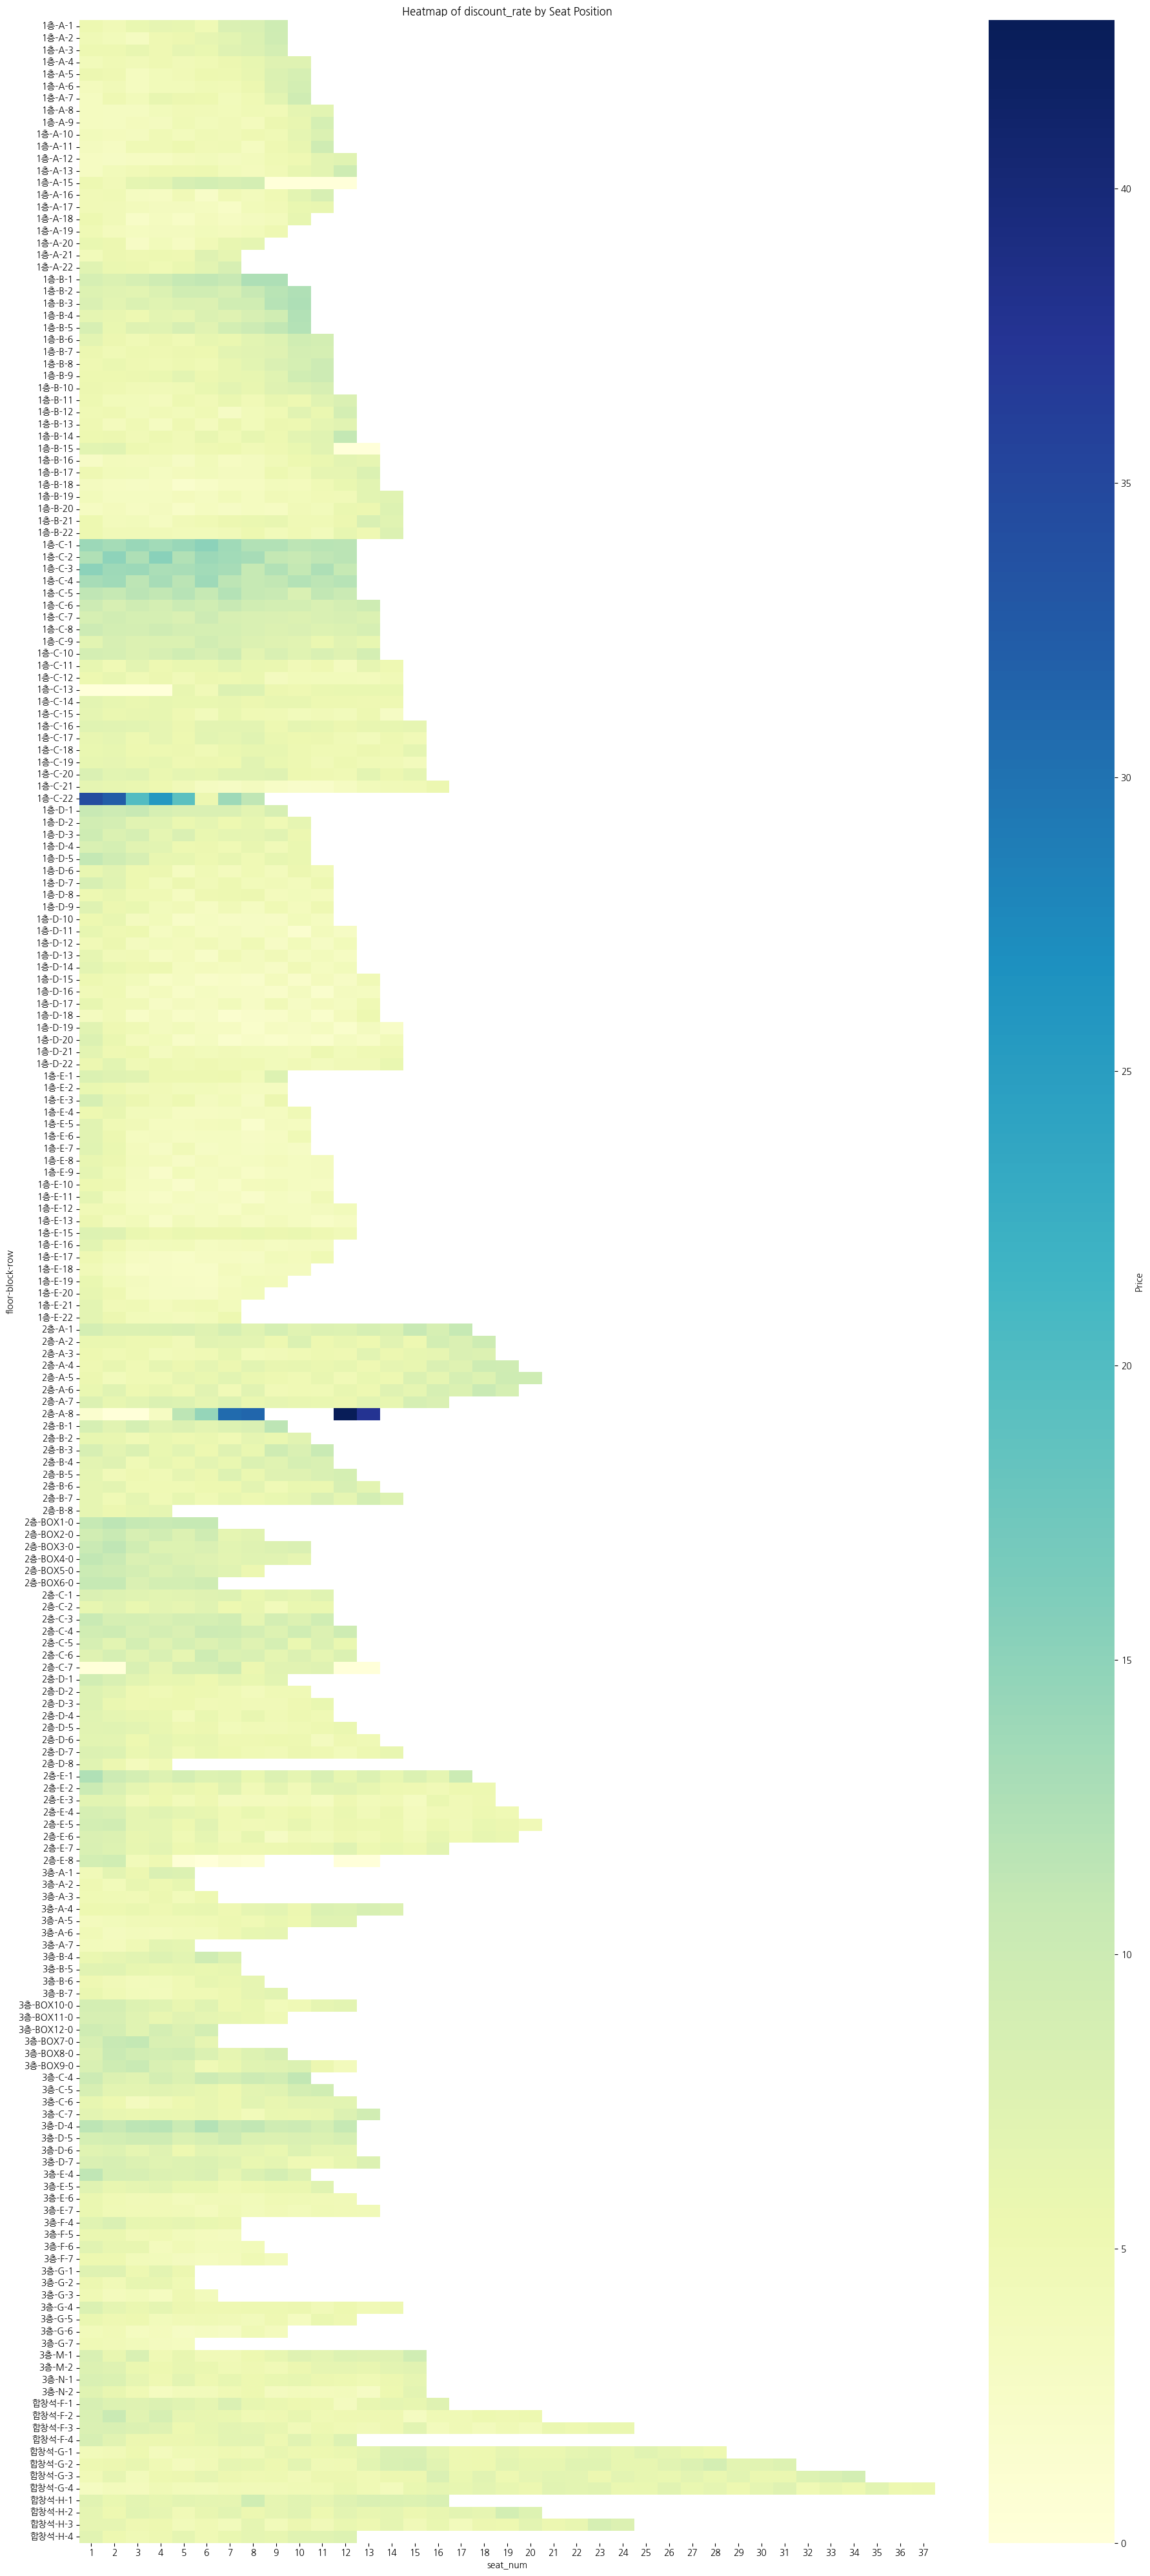

In [13]:
# 데이터 추출
grouped_data_discount_rate = df.groupby(['floor', 'block', 'row', 'seat_num'])['discount_rate'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_discount_rate = grouped_data_discount_rate.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='discount_rate')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_discount_rate, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Price'})
ax.set_title('Heatmap of discount_rate by Seat Position')


plt.tight_layout()
plt.show()

        discount_rate(초대권, 기획사 판매 포함)

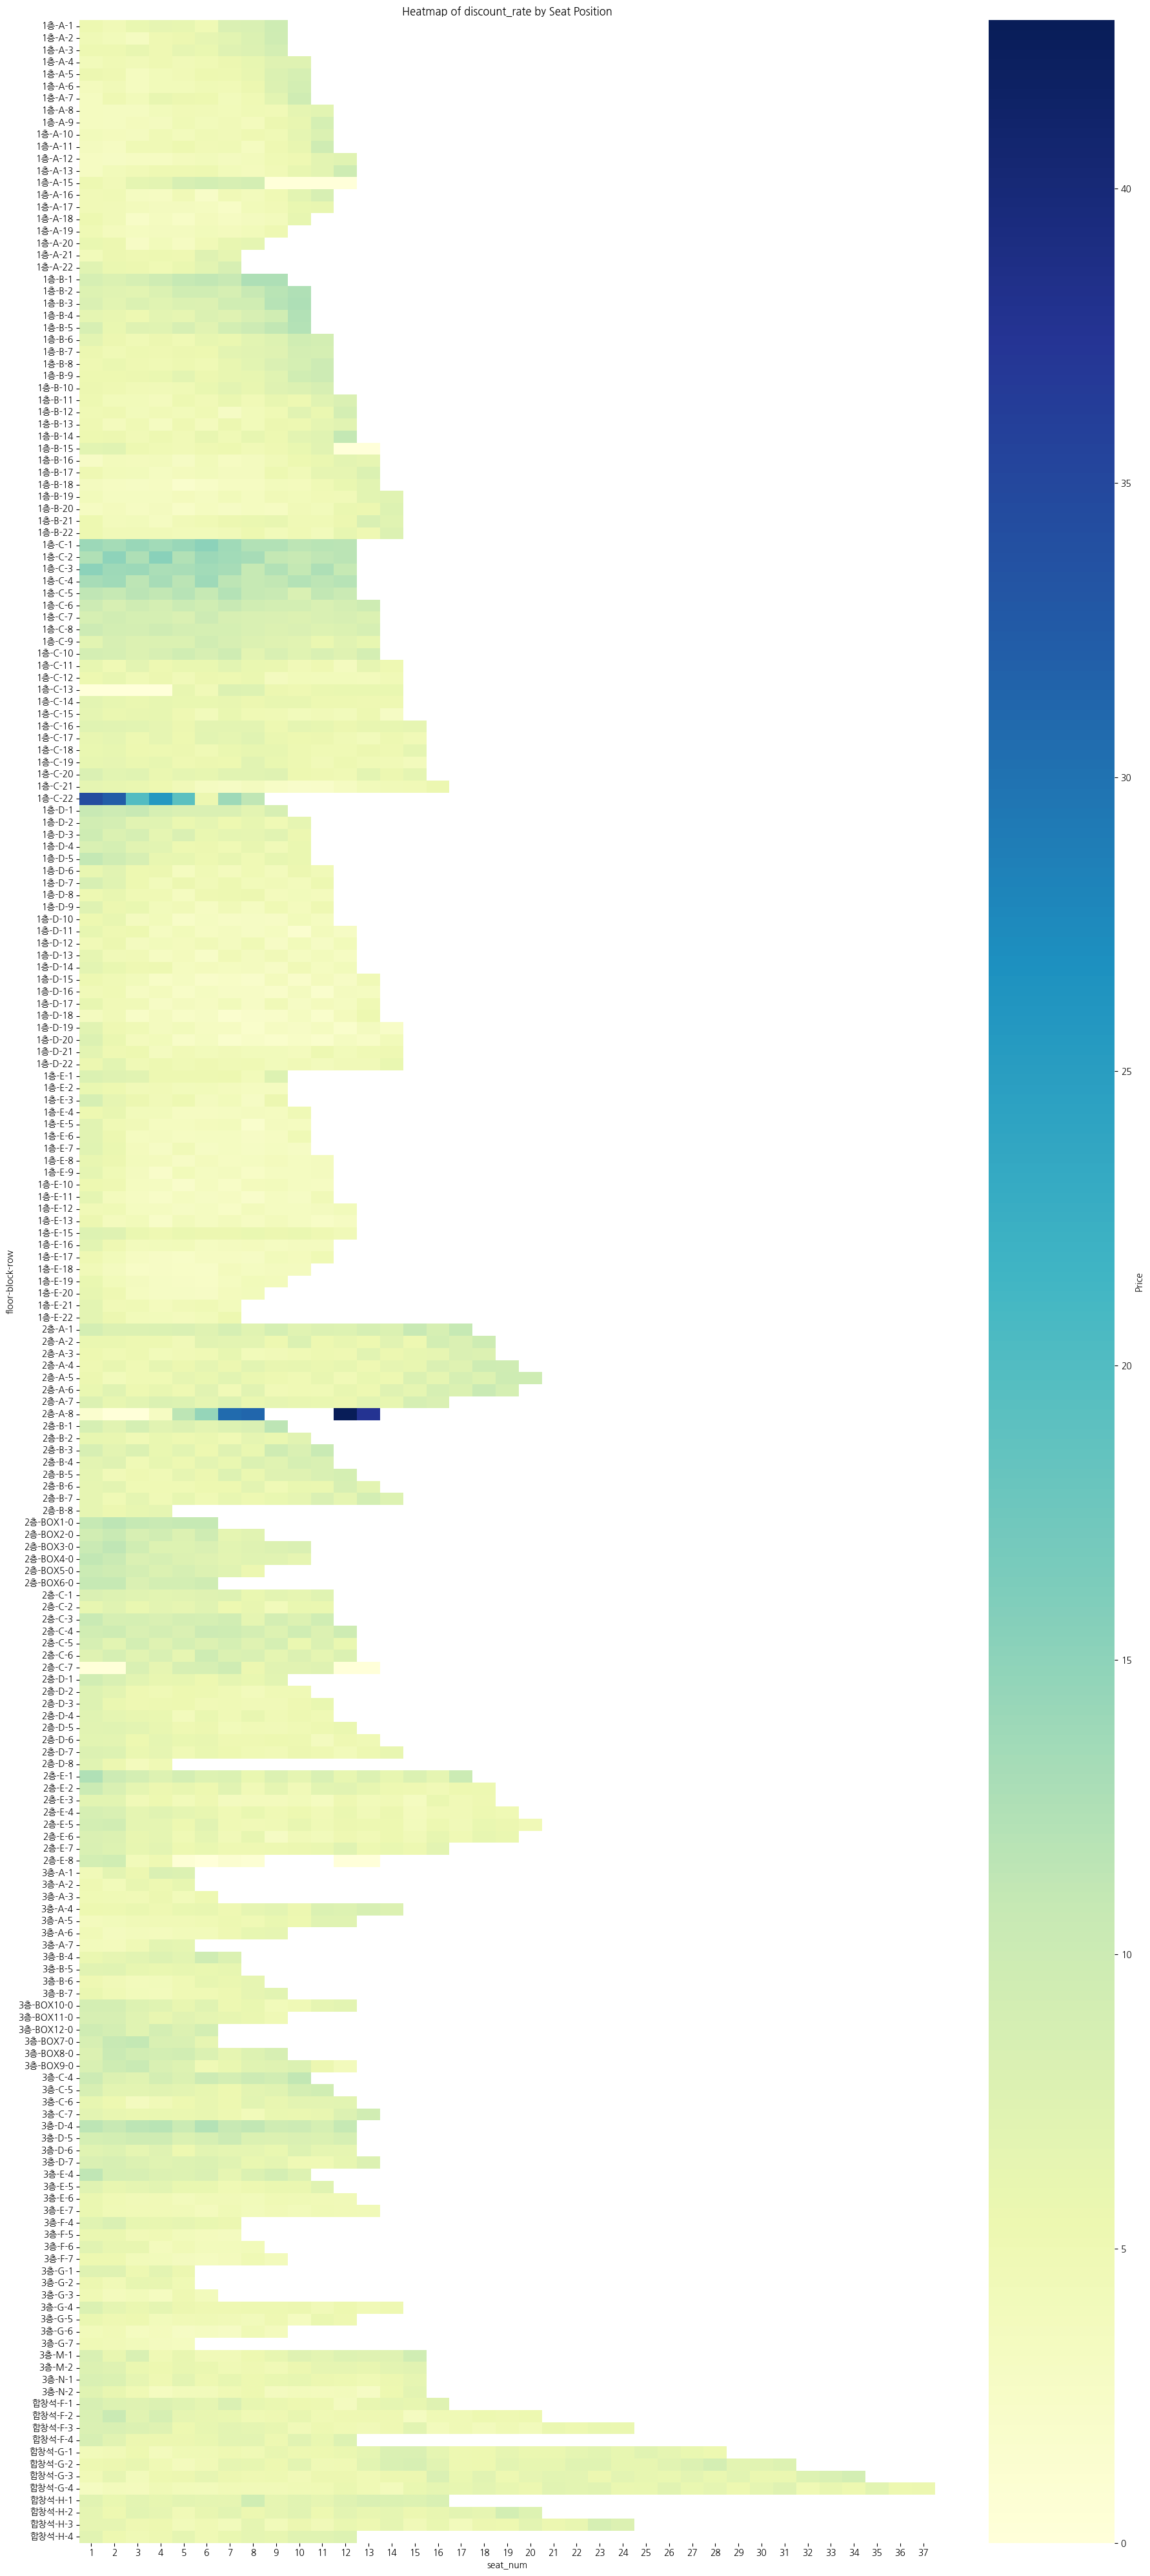

In [14]:
# 데이터 추출
grouped_data_discount_rate = data.groupby(['floor', 'block', 'row', 'seat_num'])['discount_rate'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_discount_rate = grouped_data_discount_rate.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='discount_rate')

# 시각화
fig, ax = plt.subplots(figsize=(18,40))

sns.heatmap(heatmap_data_discount_rate, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Price'})
ax.set_title('Heatmap of discount_rate by Seat Position')


plt.tight_layout()
plt.show()